<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/split-and-simple-perturb/sequences/P2C1_Optimization/P2C1_Sequence1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is part of a test for an upcoming text book on computational neuroscience from an optimization and learning perspective. The book will start with evolution because ultimately, all aspects of the brain are shaped by evolution and, as we will see, evolution can also be seen as an optimization algorithm. We are sharing it now to get feedback on what works and what does not and the developments we should do.

___
# **2.1.1: Optimization in One Dimension: Intuitions**
In the first part of the book we gained insight into what the brain is for: rapid acquisition of adaptive behaviours. Now that we know what a brain is for, we are going to start thinking about how it does what it needs to do. Instead of taking a bottom up approach grounded in observed physiological mechanisms, we are going to use a problem oriented, top down approach. That is, we will think about what problems the brain is solving and then survey the various physiological mechanisms that could feasibly implement algorithms that solve those problems. We will start with problems that are simple to understand from a statistical and mathematical perspective; basic optimization and then a broad sub-field of machine learning known as supervised learning. To develop and ground our intutions, in particular around problem scale, we start with some very simple problems.

In our last chapter, 1.4 Life is Reinforcment Learning, we introduced the idea that within life time learning of an organism can be understood as solving a particular set of reinforcment learning problems selected for by the evolutionary process. In particular we view the evolutionary process as selecting both the intrinsic reward signals (i.e. which kinds of base sensory inputs are are intrisicially rewarding) and the neural plasticity rules by which the sensory to behaviour function is updated using these reward signals. That is evolution selects for both the goals and the method of learning, chosing sensory grounded goals that guide behaviour towards being adaptive in the evolutionary sense (survival and reproduction) and learning methods that *quickly* develop these adaptive behaviours. We will come back to RL in the 4th part of this book but before we do we want to ground ourselves in a general optimization perspective.

### Objective: Solve simple optimization problems using perturbation methods, and connect these methods with physiological neural plasticity mechanisms.

In this sequence we will:

* Introduce and review the fundamental ideas of optimization.

* Introduce the perturb -> measure -> update learning rule

* Introduce a simple visual (binary) discrimination tasks

* Show how perturb -> measure -> update can be used to train a simple 'neural circuit' model which 'learns' to solve this simple binary discrimination problems based on scalar reward feedback.


# Setup

Run the following cell to setup and install the various dependencies and helper functions for this .

In [1]:
# @title Dependencies, Imports and Setup
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**
!apt install libgraphviz-dev > /dev/null 2> /dev/null #colab
!pip install ipympl pygraphviz vibecheck datatops jupyterquiz ucimlrepo > /dev/null 2> /dev/null #google.colab

import requests
from requests.exceptions import RequestException
import numpy as np
import itertools
import collections
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation
import seaborn as sns
import pandas as pd
import pygraphviz as pgv
import ipywidgets as widgets
import time
import logging
import random
import os
import copy
import torch
import warnings
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from io import BytesIO
from enum import Enum
from scipy.spatial.distance import cdist
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown, HTML, Image
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path
from typing import List, Dict
from tqdm.notebook import tqdm
from ucimlrepo import fetch_ucirepo

data_set = fetch_ucirepo(id=80)
X = data_set.data.features.values
# Translate the data to have a minimum of 0
X_translated = X - X.min()
# Scale the data to have a range from 0 to 12 (which is 6 - (-6))
scaling_factor = 12 / (X.max() - X.min())
X_scaled = X_translated * scaling_factor
# Finally, shift the data to be centered between -6 and 6
X_final = X_scaled - 6

y = data_set.data.targets.values
rng = np.random.default_rng(seed=2021)
scramble_permutation = rng.permutation(X.shape[1])
Xs = X_final[:, scramble_permutation]
y1 = y % 2
y2 = np.array(y >= 5, dtype=y.dtype)
simple_index = ((y.flatten()==1) | (y.flatten()==0))
X_simple = Xs[simple_index]
y1_simple = y1[simple_index]
# if you only had one feature which would likely be best for discrimination
epsilon = 10
class_a_sep = np.mean(X_simple[y1_simple.flatten() == 1, :], axis=0) / (np.std(X_simple[y1_simple.flatten() == 1, :], axis=0) + epsilon)
class_b_sep = np.mean(X_simple[y1_simple.flatten() == 0, :], axis=0) / (np.std(X_simple[y1_simple.flatten() == 0, :], axis=0) + epsilon)
best_feature = np.argmax(class_a_sep - class_b_sep)
print(f'Best feature is {best_feature}')
X_simple_1_feature = X_simple[:, [best_feature]]

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# random seed settings and
# getting torch to use gpu if it's there


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("This notebook isn't using and doesn't need a GPU. Good.")
  else:
    print("GPU is enabled in this notebook but not needed.")
    print("If possible, in the menu under `Runtime` -> ")
    print("`Change runtime type.`  select `CPU`")

  return device


SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()


def printmd(string):
  display(Markdown(string))


# the different utility .py files used in this notebook
filenames = []
# just run the code straight out of the response, no local copies needed!
for filename in filenames:
  url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/utils/{filename}'
  response = requests.get(url)
  # Check that we got a valid response
  if response.status_code == 200:
    code = response.content.decode()
    exec(code)
  else:
    print(f'Failed to download {url}')

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  from google.colab import data_table
  data_table.disable_dataframe_formatter()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


def remove_ip_clutter(fig):
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()


def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P2C1_S1"

Best feature is 21
Random seed 2021 has been set.
This notebook isn't using and doesn't need a GPU. Good.
Running in colab


# 2.1.1.1: Optimizing a Polynomial Analytically



In general, optimization problems are of the form: "Find some set of parameters or values, say $x$, such some other scalar valued quantity which depends in some way on those values, say $f(x)$, is as large (or small) as possible, subject to some constraints on the possible valuues of $x$."

Here's an example. Find a value of $x$ in on the interval $[-2, 2]$ such that $y = -x^2 + 2x + 3$ is as large as possible. This might be written more teresely with symbols as:

$$\underset{x\in[-2,2]}{\arg \max}(-x^2 + 2x + 3)  $$

If you have taken (and remember!) a calculus course you might think to yourself, "Oh, I know how to do that". First we take the derivative,

$$
\frac{\text{d}}{\text{d}x} -x^2 + 2x + 3 = -2x + 2
$$

then we set that equal to zero and solve for the extrema

$$
\begin{align}
-2x + 2 &= 0 \\
x &= 1
\end{align}
$$

If you really dig into your calculus memories (if you have them) you might recall that you also need to check the concavity to see if this zero-derivative point is a maximum or a minimum. That is
$$
\left. \frac{\text{d}^2}{\text{d}x^2} -x^2 + 2x + 3 \right|_{x=1}= -2
$$

So that zero-derivative point is a maximum. Difficult to rememeber which sign means which but looking at a picture this seems to be right.

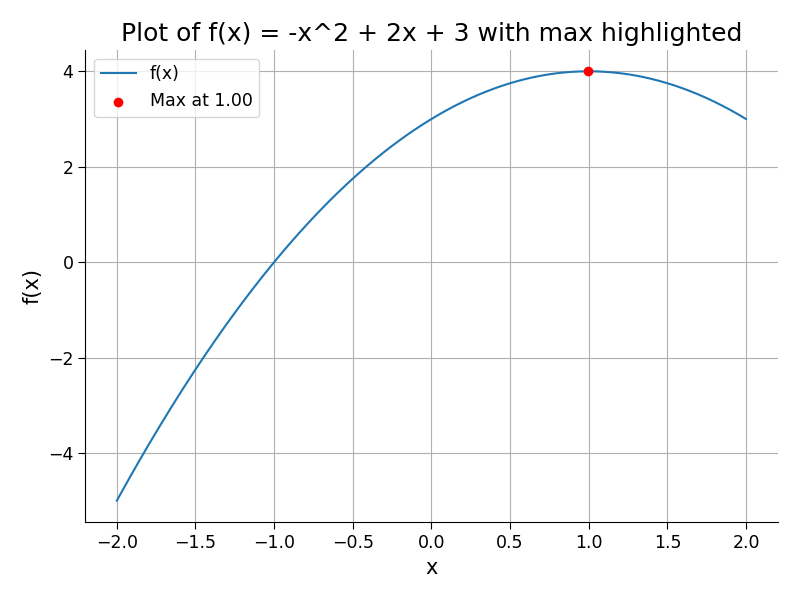

In [2]:
# @markdown **Run this cell** to plot the function we are optimizing

def f(x):
  return -(x-1)**2 + 4

x = np.linspace(-2, 2, 400)
y = f(x)

ymax = np.max(y)
xmax = x[np.argmax(y)]

fig, ax = plt.subplots(figsize=(8, 6))
# Plot the function
ax.plot(x, y, label='f(x)')
ax.scatter(xmax, ymax, color='red', label=f'Max at {xmax:.2f}', zorder=5)
ax.set_title('Plot of f(x) = -x^2 + 2x + 3 with max highlighted')
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.legend()
plt.grid(True)
plt.show()


If the parabola were opening up instead of down the maximum would have been on the edges, so we should have checked those as well. This method works well, but grounded as it is in symbolic computation of derivatives and algebraic manipulation, this seems an unlikely optimization method to be implemented generally in the brain. Can we solve this same problem with a simpler method.Let's try our go to propose and reject algorithm. Run the cell below to manually implement the propose and reject algorithm on this problem.

**Math Exercise**
1. Use our little calculus review to come up with a formula for the max/min of *any* parabola, parameterized by coefficients $a$, $b$, and $c$ as

$$f(x) = a(x-b)^2 + c$$
(Answer: The max/min occurs at $x=b$, it is a min if $a$ is positive and a max if $a$ is negative. If the min occurs at $b$ the maximum will be at a boundary point. If the max occurs at $b$ the minium will be at a boundary point.


# 2.1.1.2: Optimizing a Polynomial with Propose and Reject
Taking derivatives, solving for zeros, taking second derivatives, checking concavity. This certainly solves the problem, but the in terms of biological plausibility we need something more simple (struggling with how to motivate this)

One of the simplest optimization strategies that exists, and one the proved quite effective in many of the cases we looked at in the first part of the book was propose and reject. Indeed evolution through natural selection is roughly runing a kind of propose (new variants through mutation and recombenation) and accept or reject alogorithm (through selective survival and reproduction) on the living world. For the sake of building intuitions let's walk through solving the same optimization problem (find the value of $x$ the maximizes some quadratic function of $f(x)$), using a propose and reject approach.

Unlike solving systems of linear equations to determine the zeros of a function, propose and reject style algorithms are much easier to imagine being implemented in the brain. E.g. the synaptic weights between some neurons are temporarily perturbed, and if the outcome of this perturbation is favourable these temporary perturbations are consolidated and made more permanent, serving as the departure point for further perturbations. This is a gross simplification, but it is a process that seems simple enough to not be dismissed out of hand.

In [3]:
# @title Stepping Through Optimization with Propose and Reject
# @markdown **Run this cell** to try your hand at manually finding the maximum of a quadratic function using propose and reject.
class InteractivePolynomialProposeReject:
  def __init__(self,
               polynomial_max = 1,
               bounds=(-4, 4),
               step_size=0.5, seed=None):
    self.polynomial_max = polynomial_max
    self.polynomial = lambda x: -(x - polynomial_max)**2 + 4
    self.bounds = bounds
    self.step_size = step_size
    self.rng = np.random.default_rng(seed)
    self.current_x = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.current_y = self.polynomial(self.current_x)
    self.proposed_x = None
    self.proposed_y = None
    self.x_history = []
    self.y_history = []
    self.proposals_evaluated = 0
    self.fig, self.ax = plt.subplots(figsize=(6, 4))
    self.propose = widgets.Button(description='Propose')
    self.accept = widgets.Button(description='Accept')
    self.reject = widgets.Button(description='Reject')
    self.reset = widgets.Button(description='Reset')
    self.accept.disabled = True  # Disable since there's no proposal initially
    self.show_history = widgets.ToggleButton(value=True, description='Show History')
    self.reject.disabled = True  # Disable since there's no proposal initially
    self.show_curve = widgets.ToggleButton(value=False, description='Show Function')
    self.init_plot()
    self.narration_display = widgets.Output()
    remove_ip_clutter(self.fig)
    # Arrange widgets in a layout
    buttons_layout = widgets.VBox([self.propose,
        widgets.HBox([self.accept, self.reject]),
        widgets.HBox([self.reset, self.show_history, self.show_curve])])
    buttons_and_narration = widgets.HBox([buttons_layout, self.narration_display])
    self.ui = widgets.VBox([self.fig.canvas, buttons_and_narration])
    #bind actions to handlers
    self.propose.on_click(self.on_propose_clicked)
    self.accept.on_click(self.on_accept_clicked)
    self.reject.on_click(self.on_reject_clicked)
    self.reset.on_click(self.on_reset_clicked)
    self.show_curve.observe(self.on_show_curve_toggled, 'value')
    self.show_history.observe(self.on_show_history_toggled, 'value')

  def init_plot(self):
    """Initialize the plot with placeholder data."""
    x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    y_vals = self.polynomial(x_vals)
    # Initial plot commands return line objects, keep references to them
    self.line_polynomial, = self.ax.plot(x_vals, y_vals, alpha=1.0, label='Polynomial Curve')
    self.point_current, = self.ax.plot([self.current_x], [self.current_y], 'bo', label='Current')
    self.point_proposed, = self.ax.plot([], [], 'rx', label='Proposed')  # Empty data to start
    self.points_history, = self.ax.plot([], [], 'ks', alpha=0.5, label='History')  # Empty data to start
    self.ax.legend()
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_propose_clicked(self, button):
    self.proposals_evaluated += 1
    perturbation = self.rng.standard_normal() * self.step_size
    self.proposed_x = self.current_x + perturbation
    self.proposed_y = self.polynomial(self.proposed_x)
    self.point_proposed.set_data([self.proposed_x], [self.proposed_y])
    self.fig.canvas.draw_idle()
    #self.update_plot()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Proposed x: {self.proposed_x:.3f}, y: {self.proposed_y:.3f}.')
      print(f' Current x: {self.current_x:.3f}, y: {self.current_y:.3f}.')
      print("Click accept or reject to accept or reject this proposed x?")
      print(f'Proposals evaluated so far: {self.proposals_evaluated}')
    self.accept.disabled = False
    self.reject.disabled = False
    self.propose.disabled = True

  def on_accept_clicked(self, button):
    with self.narration_display:
      clear_output(wait=True)
      print(f'Accepted x: {self.proposed_x:.3f}, y: {self.proposed_y:.3f}.')
      print(f'Click propose to try a new value.')
    self.x_history.append(self.current_x)
    self.y_history.append(self.current_y)
    self.current_x = self.proposed_x
    self.current_y = self.proposed_y
    self.proposed_x = None
    self.proposed_y = None
    self.point_current.set_data([self.current_x], [self.current_y])
    self.points_history.set_data(self.x_history, self.y_history)
    self.point_proposed.set_data([], [])
    self.fig.canvas.draw_idle()
    self.accept.disabled = True
    self.reject.disabled = True
    self.propose.disabled = False

  def on_reject_clicked(self, button):
    with self.narration_display:
      clear_output(wait=True)
      print(f'Rejected x: {self.proposed_x:.3f}, y: {self.proposed_y:.3f}.')
      print(f' Keeping x: {self.current_x:.3f}, y: {self.current_y:.3f}.')
      print(f'Click propose to try a new value.')
    self.proposed_x = None
    self.proposed_y = None
    self.point_proposed.set_data([], [])
    self.fig.canvas.draw_idle()
    self.accept.disabled = True
    self.reject.disabled = True
    self.propose.disabled = False

  def on_reset_clicked(self, button):
    self.proposals_evaluated = 0
    with self.narration_display:
      clear_output(wait=True)
      print(f'Reset. Clearing history')
      print(f'Generating a new curve for you to find the max of.')
    self.polynomial_max = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.polynomial = lambda x: -(x - self.polynomial_max)**2 + 5
    x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    y_vals = self.polynomial(x_vals)
    self.line_polynomial.set_data(x_vals, y_vals)
    min_y, max_y = min(y_vals), max(y_vals)
    padding = (max_y - min_y) * 0.1  # Add some padding to the limits
    self.ax.set_ylim(min_y - padding, max_y + padding)
    self.current_x = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.current_y = self.polynomial(self.current_x)
    self.proposed_x = None
    self.proposed_y = None
    self.x_history = []
    self.y_history = []
    self.accept.disabled = True
    self.reject.disabled = True
    self.propose.disabled = False
    self.point_current.set_data([self.current_x], [self.current_y])
    self.points_history.set_data(self.x_history, self.y_history)
    self.point_proposed.set_data([], [])
    self.fig.canvas.draw_idle()

  def on_show_curve_toggled(self, change):
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_show_history_toggled(self, change):
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()



ippr = InteractivePolynomialProposeReject()
display(ippr.fig.canvas)
clear_output()
display(ippr.ui)

So that works pretty well, but whenever the proposed step is in the "wrong" direction we don't make any progress towards a better $x$ value. So although propose and reject has a nice ratcheting feature, that is we never pick an $x$ value that is worse than the one we currently have, we can potentially waste a lot of evaluations on test steps in the wrong direction. One clever idea here is to make updates in the opposite direction whenever the evaluation is less than the current level. So we've changed the question from "Is this a good new point to jump to?" to "In which direction should I change the parameter?" This leaves open the question of how far to step in that opposite direction. For now let's just try stepping as far as the initially proposed step but in the opposite direction.

In [4]:
# @title Manual Optimization with Modified Propose and Reject (always step)
# @markdown **Run this cell** to try your hand at manually finding the maximum of a quadratic function with this modified Propose and Reject method.
class InteractivePolynomialTestStep:
  def __init__(self,
               polynomial_max = 1,
               bounds=(-4, 4),
               step_size=0.5, seed=None):
    self.polynomial_max = polynomial_max
    self.polynomial = lambda x: -(x - polynomial_max)**2 + 4
    self.bounds = bounds
    self.step_size = step_size
    self.rng = np.random.default_rng(seed)
    self.current_x = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.current_y = self.polynomial(self.current_x)
    self.proposed_x = None
    self.proposed_y = None
    self.x_history = []
    self.y_history = []
    self.proposals_evaluated = 0
    self.fig, self.ax = plt.subplots(figsize=(6, 4))
    self.propose = widgets.Button(description='Propose')
    self.take_step = widgets.Button(description='Take Step')
    self.reset = widgets.Button(description='Reset')
    self.take_step.disabled = True  # Disable since there's no proposal initially
    self.show_history = widgets.ToggleButton(value=True, description='Show History')
    self.show_curve = widgets.ToggleButton(value=False, description='Show Function')
    self.init_plot()
    self.narration_display = widgets.Output()
    remove_ip_clutter(self.fig)
    # Arrange widgets in a layout
    buttons_layout = widgets.VBox([
        widgets.HBox([self.propose, self.take_step]),
        widgets.HBox([self.reset, self.show_history, self.show_curve])])
    buttons_and_narration = widgets.HBox([buttons_layout, self.narration_display])
    self.ui = widgets.VBox([self.fig.canvas, buttons_and_narration])
    #bind actions to handlers
    self.propose.on_click(self.on_propose_clicked)
    self.take_step.on_click(self.on_take_step_clicked)
    self.reset.on_click(self.on_reset_clicked)
    self.show_curve.observe(self.on_show_curve_toggled, 'value')
    self.show_history.observe(self.on_show_history_toggled, 'value')

  def init_plot(self):
    """Initialize the plot with placeholder data."""
    x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    y_vals = self.polynomial(x_vals)
    # Initial plot commands return line objects, keep references to them
    self.line_polynomial, = self.ax.plot(x_vals, y_vals, alpha=1.0, label='Polynomial Curve')
    self.point_current, = self.ax.plot([self.current_x], [self.current_y], 'bo', label='Current')
    self.point_proposed, = self.ax.plot([], [], 'rx', label='Proposed')  # Empty data to start
    self.points_history, = self.ax.plot([], [], 'ks', alpha=0.5, label='History')  # Empty data to start
    self.ax.legend()
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_propose_clicked(self, button):
    self.proposals_evaluated += 1
    perturbation = self.rng.standard_normal() * self.step_size
    self.proposed_x = self.current_x + perturbation
    self.proposed_y = self.polynomial(self.proposed_x)
    self.point_proposed.set_data([self.proposed_x], [self.proposed_y])
    self.fig.canvas.draw_idle()
    #self.update_plot()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Proposed x: {self.proposed_x:.3f}, y: {self.proposed_y:.3f}.')
      print(f' Current x: {self.current_x:.3f}, y: {self.current_y:.3f}.')
      print("Click take step to update x?")
      print(f'Proposals evaluated so far: {self.proposals_evaluated}')
    self.take_step.disabled = False
    self.propose.disabled = True

  def on_take_step_clicked(self, button):
    if self.proposed_y > self.current_y:
      with self.narration_display:
        clear_output(wait=True)
        print('Proposed is better stepping to proposed')
        print(f'Step to x: {self.proposed_x:.3f}, y: {self.proposed_y:.3f}.')
        print(f'Click propose to try a new value.')
      self.x_history.append(self.current_x)
      self.y_history.append(self.current_y)
      self.current_x = self.proposed_x
      self.current_y = self.proposed_y
      self.proposed_x = None
      self.proposed_y = None
      self.point_current.set_data([self.current_x], [self.current_y])
      self.points_history.set_data(self.x_history, self.y_history)
      self.point_proposed.set_data([], [])
    elif self.proposed_y < self.current_y:
      mirror_x = self.current_x - (self.proposed_x - self.current_x)
      mirror_y = self.polynomial(mirror_x)
      with self.narration_display:
        clear_output(wait=True)
        print('Proposed is not as good as current, going in the opposite direction.')
        print(f'Step to x: {mirror_x:.3f}, y: {mirror_y:.3f}.')
        print(f'Click propose to try a new value.')
      self.x_history.append(self.current_x)
      self.y_history.append(self.current_y)
      self.current_x = mirror_x
      self.current_y = mirror_y
      self.proposed_x = None
      self.proposed_y = None
      self.point_current.set_data([self.current_x], [self.current_y])
      self.points_history.set_data(self.x_history, self.y_history)
      self.point_proposed.set_data([], [])
    self.fig.canvas.draw_idle()
    self.take_step.disabled = True
    self.propose.disabled = False

  def on_reset_clicked(self, button):
    self.proposals_evaluated = 0
    with self.narration_display:
      clear_output(wait=True)
      print(f'Reset. Clearing history')
      print(f'Generating a new curve for you to find the max of.')
    self.polynomial_max = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.polynomial = lambda x: -(x - self.polynomial_max)**2 + 5
    x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    y_vals = self.polynomial(x_vals)
    self.line_polynomial.set_data(x_vals, y_vals)
    min_y, max_y = min(y_vals), max(y_vals)
    padding = (max_y - min_y) * 0.1  # Add some padding to the limits
    self.ax.set_ylim(min_y - padding, max_y + padding)
    self.current_x = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.current_y = self.polynomial(self.current_x)
    self.proposed_x = None
    self.proposed_y = None
    self.x_history = []
    self.y_history = []
    self.take_step.disabled = True
    self.propose.disabled = False
    self.point_current.set_data([self.current_x], [self.current_y])
    self.points_history.set_data(self.x_history, self.y_history)
    self.point_proposed.set_data([], [])
    self.fig.canvas.draw_idle()

  def on_show_curve_toggled(self, change):
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_show_history_toggled(self, change):
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()



ipts = InteractivePolynomialTestStep()
display(ipts.fig.canvas)
clear_output()
display(ipts.ui)

So that is more efficeint at first, but when we get close to the maximum, as a result of "over-shooting", we sometimes take steps further away from the optima. And, unlike classic propose and reject,  there is no ratcheting mechanism, i.e. we will step to worse $x$ values. This modification might get us in neighbourhood of the maximum more quickly, but it does not work as well for dialing in the precise location of the maximum. We could fiddle around with step size to mitigate this issue, but we will always face some tradeoff, where large step sizes are helpful in the beggining to quickly get in the rough neighbourhood of the maximum and smaller step sizes are better once we are close to the maximum to dial in the maximum precisely. Without a sense of how close or far away the maximum is, it is difficult to choose an appropriate step size.

# 2.1.1.3 Optimizing a Polynomial with Perturb-Measure-Step

One way to get around this issue is to think a little more about what we can do with the information gleaned from evaluating a proposed value. In propose and reject we just ask "Is this better?". In our modification of propose and reject we ask "Is this the right direction to be stepping?", but we can ask an even more nuanced question, "Based on our a comparison of this proposed $x$ with the current value, how does $f(x)$ change with $x$ around the current point, and given this, how far and in which direction should we step?" Another way of saying this is: "What is the slope of the line between my current point and my proposed point? I'll take a step that is proportional to the slope." That is we can use slope to address both how far to step *and* in which direction. Before, in propose and reject our test point, and our parameter step were one and the same. In this new method, the test point and the parameter step have been seperated from each other. With evaluation at the current point and a nearby test point informing (but typically not being) the next iteration of the parameter value.

In [5]:
# @title Optimization with Perturb-Measure-Step
# @markdown **Run this cell** to step through finding the maximum of a quadratic function using a perturb-measure-step approach.
class InteractivePolynomialSlopeStepper:
  def __init__(self,
               polynomial_max = 1,
               bounds=(-2, 2),
               test_step_size=0.1,
               x_step_size=0.2,
               adjustable_step_size=False,
               seed=None):
    self.polynomial_max = polynomial_max
    self.polynomial = lambda x: -(x - polynomial_max)**2 + 5
    self.bounds = bounds
    self.test_step_slider = widgets.FloatSlider(value=test_step_size, min=-0.5, max=0.5, step=0.01,
                                                    description='Test Step:', readout=True, readout_format='.2f')
    self.x_step_slider = widgets.FloatSlider(value=x_step_size, min=0.01, max=1.5, step=0.01,
                                                    description='x Step:', readout=True, readout_format='.2f')
    self.adjustable_step_size = adjustable_step_size
    self.rng = np.random.default_rng(seed)
    self.current_x = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.current_y = self.polynomial(self.current_x)
    self.test_x = None
    self.test_y = None
    self.step_x = None
    self.step_y = None
    self.x_history = []
    self.y_history = []
    self.points_tested = 0
    self.fig, self.ax = plt.subplots(figsize=(6, 4))

    self.perturb = widgets.Button(description='Perturb')
    self.measure = widgets.Button(description='Measure')
    self.measure.disabled = True
    self.step = widgets.Button(description='Step')
    self.step.disabled = True

    self.reset = widgets.Button(description='Reset')
    self.show_history = widgets.ToggleButton(value=True, description='Show History')
    self.show_curve = widgets.ToggleButton(value=False, description='Show Function')
    self.init_plot()
    self.narration_display = widgets.Output()
    remove_ip_clutter(self.fig)

    # Arrange widgets in a layout
    if self.adjustable_step_size:
      buttons_layout = widgets.VBox([
        widgets.HBox([self.perturb, self.measure, self.step]),
        self.test_step_slider,
        self.x_step_slider,
        widgets.HBox([self.reset, self.show_history, self.show_curve])])
    else:
      buttons_layout = widgets.VBox([
        widgets.HBox([self.perturb, self.measure, self.step]),
        widgets.HBox([self.reset, self.show_history, self.show_curve])])
    buttons_and_narration = widgets.HBox([buttons_layout, self.narration_display])
    self.ui = widgets.VBox([self.fig.canvas, buttons_and_narration])

    #bind actions to handlers
    self.perturb.on_click(self.on_perturb_clicked)
    self.measure.on_click(self.on_measure_clicked)
    self.step.on_click(self.on_step_clicked)
    self.reset.on_click(self.on_reset_clicked)
    self.show_curve.observe(self.on_show_curve_toggled, 'value')
    self.show_history.observe(self.on_show_history_toggled, 'value')
    self.x_step_slider.observe(self.on_x_step_slider_changed, 'value')
    self.test_step_slider.observe(self.on_test_step_slider_changed, 'value')

  def on_x_step_slider_changed(self, change):
    self.step_x = self.current_x + self.x_step_slider.value * self.slope
    self.step_y = self.slope * self.step_x + self.y_intercept
    self.step_point.set_data([self.step_x], [self.step_y])
    y_min, y_max = self.ax.get_ylim()
    self.step_vline.set_data([self.step_x, self.step_x], [y_min, self.step_y])
    self.fig.canvas.draw_idle()

  def on_test_step_slider_changed(self, change):
    if self.test_step_slider.value == 0:
      # Set to a default non-zero value
      self.test_step_slider.value = 0.01
      with self.narration_display:
        print(f"Test step size of 0 cannot be used to calculate slope. Using 0.01 to avoid division by zero in slope calculation.")
    self.test_x = self.current_x + self.test_step_slider.value
    self.test_y = self.polynomial(self.test_x)
    self.test_point.set_data([self.test_x], [self.test_y])
    if self.step_x is not None:
      rise = self.test_y - self.current_y
      run = self.test_x - self.current_x
      self.slope = rise / run
      self.y_intercept = self.current_y - self.slope * self.current_x
      x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
      y_vals = self.slope * x_vals + self.y_intercept
      self.step_line.set_data(x_vals, y_vals)
      self.step_x = self.current_x + self.x_step_slider.value * self.slope
      self.step_y = self.slope * self.step_x + self.y_intercept
      self.step_point.set_data([self.step_x], [self.step_y])
      y_min, y_max = self.ax.get_ylim()
      self.step_vline.set_data([self.step_x, self.step_x], [y_min, self.step_y])
    self.fig.canvas.draw_idle()

  def init_plot(self):
    """Initialize the plot with placeholder data."""
    x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    y_vals = self.polynomial(x_vals)
    # Initial plot commands return line objects, keep references to them
    self.point_current, = self.ax.plot([self.current_x], [self.current_y], 'bo', label='Current')
    self.test_point, = self.ax.plot([], [], 'rx', label='Test Point')  # Empty data to start
    self.step_point, = self.ax.plot([], [], 'go', label='Step Point')  # Empty data to start
    self.points_history, = self.ax.plot([], [], 'ks', alpha=0.5, label='History')  # Empty data to start
    self.line_polynomial, = self.ax.plot(x_vals, y_vals, alpha=1.0, label='Polynomial Curve')
    self.slope = 0
    self.y_intercept = self.current_y - self.slope * self.current_x
    self.step_line, = self.ax.plot([], [], 'r', label='Measure')
    self.step_vline, = self.ax.plot([], [], 'g', linestyle='--')
    self.ax.legend()
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_perturb_clicked(self, button):
    self.points_tested += 1
    self.test_x = self.current_x + self.test_step_slider.value
    self.test_y = self.polynomial(self.test_x)
    self.test_point.set_data([self.test_x], [self.test_y])
    self.fig.canvas.draw_idle()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Test x: {self.test_x:.3f}, y: {self.test_y:.3f}.')
      print(f'Current x: {self.current_x:.3f}, y: {self.current_y:.3f}.')
      print("Click measure to evaluate the slope based on this test point")
    self.measure.disabled = False
    self.perturb.disabled = True

  def on_measure_clicked(self, button):
    rise = self.test_y - self.current_y
    run = self.test_x - self.current_x
    self.slope = rise / run
    self.y_intercept = self.current_y - self.slope * self.current_x
    x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    y_vals = self.slope * x_vals + self.y_intercept
    self.step_line.set_data(x_vals, y_vals)
    self.step_x = self.current_x + self.x_step_slider.value * self.slope
    self.step_y = self.slope * self.step_x + self.y_intercept
    self.step_point.set_data([self.step_x], [self.step_y])
    y_min, y_max = self.ax.get_ylim()
    self.step_vline.set_data([self.step_x, self.step_x], [y_min, self.step_y])
    self.fig.canvas.draw_idle()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Based on slope measurement proposed step from {self.current_x:.3f} to {self.step_x:.3f}')
      print("Click step, to make the step.")

    self.step.disabled = False
    self.measure.disabled = True

  def on_step_clicked(self, button):
    new_y = self.polynomial(self.step_x)
    with self.narration_display:
      clear_output(wait=True)
      print(f'Stepped to x: {self.step_x:.3f}')
      print(f'Actual y value there is {new_y:.3f}')
      print(f'Click perturb to test a new value.')
    self.x_history.append(self.current_x)
    self.y_history.append(self.current_y)
    self.points_history.set_data(self.x_history, self.y_history)
    self.current_x = self.step_x
    self.current_y = new_y
    self.point_current.set_data([self.current_x], [self.current_y])
    self.test_x = None
    self.test_y = None
    self.test_point.set_data([], [])
    self.step_x = None
    self.step_y = None
    self.step_point.set_data([], [])
    self.step_line.set_data([], [])
    self.step_vline.set_data([], [])
    self.fig.canvas.draw_idle()
    self.step.disabled = True
    self.perturb.disabled = False

  def on_reset_clicked(self, button):
    self.proposals_evaluated = 0
    with self.narration_display:
      clear_output(wait=True)
      print(f'Reset. Clearing history')
      print(f'Generating a new curve for you to find the max of.')
    self.polynomial_max = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.polynomial = lambda x: -(x - self.polynomial_max)**2 + 5
    x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    y_vals = self.polynomial(x_vals)
    self.line_polynomial.set_data(x_vals, y_vals)
    min_y, max_y = min(y_vals), max(y_vals)
    padding = (max_y - min_y) * 0.1  # Add some padding to the limits
    self.ax.set_ylim(min_y - padding, max_y + padding)
    self.current_x = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.current_y = self.polynomial(self.current_x)
    self.test_x = None
    self.test_y = None
    self.step_x = None
    self.step_y = None
    self.x_history = []
    self.y_history = []
    self.step.disabled = True
    self.perturb.disabled = False
    self.point_current.set_data([self.current_x], [self.current_y])
    self.points_history.set_data(self.x_history, self.y_history)
    self.test_point.set_data([], [])
    self.step_point.set_data([], [])
    self.fig.canvas.draw_idle()

  def on_show_curve_toggled(self, change):
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_show_history_toggled(self, change):
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()



ipss = InteractivePolynomialSlopeStepper()
display(ipss.fig.canvas)
clear_output()
display(ipss.ui)

Wow, that works great. We always take a step in the right direction. The steps are big when we are far away from the maximum, and the steps get smaller as we get closer to the maximum, so that we aren't stepping very far away from it the maximum when we do overshoot it. Now, again if you ever took a calculus course, you might have guessed that the reason this works so well is that the slope between two close test points is an approximation of the derivative, and so when we take step sizes that are proportional and in the direction of the slope we are gaurenteed to take smaller step sizes as we approach the maximum. Also important, these gradient approximating steps will almost always increase the value, except in cases of overshooting which occur when we are closer to the maximum than our test step. However, if we have a small enough parameter step size we will not overshoot by much and we will correct on the next step. And if we have a small enough test step size this will only happen when we are very close to the maximum. To get a sense of how both test step size and parameter step size matter, use the sliders to play with these two different step size parameters in the widget below.

In [6]:
# @title Playing with step sizes in Perturb-Measure-Step
# @markdown **Run this cell** to play with the effect of step-size on the perturb-measure-step approach.
ipss2 = InteractivePolynomialSlopeStepper(adjustable_step_size=True)
display(ipss2.fig.canvas)
clear_output()
display(ipss2.ui)

Exploration Exercise:
In the widget above adjuste x step and test step so that
1. The current value $x$ of slowly approaches the maximizing value without ever quite getting there, or overshooting.
2. The current value $x$ slowly approaches the maximizing value, but overshoots on each iteration (potentially after a few initial iterations). This is sometimes reffered to as chattering. Chatter can still be okay so long as the process is converging on the optimal value.
3. The value of $x$ consistently overshoots and ends up further away from the optimal value, i.e. there is unstable chattering, which prevents the process from keeping $x$ close to the optimal value.
Hint: Click the "Show Function" button to view the curve you're working with.

Now that we have reviewed some foundational optimzation ideas let's see if we can adapt these ideas to some simple cartoon scenarios that start to have a tenuous connection to the kinds of problems living organisms face, when trying to survive and thrive.


#2.1.1.2: Optimizing Behaviour with Perturb-Measure-Step: The Optimal Striking Threshold

In previous chapters we motivated much of our modeling using a binary classification problem in which a lurking predator must choose between striking and not striking based on sensory input. Initially, we viewed the behavioral map from sensory input to action as genetically determined. However, we concluded the chapter on evolution by highlighting the evolutionary advantage of at least partially learning these sensory-behaviour maps within an organism's lifetime. These advantages emerge in part due to variable environments and complex behaviors with non-linear fitness impacts. Here we shift our focus and work with the case where the behavioural map from sensory input to action is to be entirely 'learned' by the organism, using feedback signals from the environment. We will use and extend the fundamental optimization concepts just introduced. But, before we build a highly abstracted model of a neural circuit together with a learning/optimization rule to solve this problem, let's see if your neural network is up to the task. Given a sensory input pattern, determine whether to strike or not. Try to maximize your average score and see how well you can perform. We will start with a very simple 'sensory' pattern.


In [7]:
# @markdown **Run this cell** to try out the 'strike-no-strike' discrimination task.

class InteractiveMNISTPredator():
  def __init__(self,
               features=Xs,
               labels=y,
               feedback_type='on_strike_only', seed=123):
    # Initialize dataset, settings for image scrambling and feedback
    self.features = features
    self.labels = labels
    # features is num_data_points x 64 (reshape to 8x8 for display, each cell 0-16)
    # labels is num_data_points x 1 (values 0-9 or 0/1 depending)
    self.feedback_type = feedback_type
    self.rng = np.random.default_rng(seed)
    sample_order = self.rng.permutation(self.features.shape[0])
    self.features = self.features[sample_order]
    self.labels = self.labels[sample_order]
    # initialize game state
    self.current_index = 0
    self.score = 0
    self.best_possible_score = 0
    self.successful_strikes = 0
    self.failed_strikes = 0
    self.non_strikes = 0
    # Initialize widgets
    self.strike_button = widgets.Button(description='Strike')
    self.no_strike_button = widgets.Button(description='No Strike')
    self.score_display = widgets.Output()
    self.feedback_display = widgets.Output()

    # Initialize the figure for image display
    self.fig, self.ax = plt.subplots(figsize=(4, 4))
    remove_ip_clutter(self.fig)
    self.show_next_image()
    # Bind event handlers
    self.strike_button.on_click(self.on_strike_clicked)
    self.no_strike_button.on_click(self.on_no_strike_clicked)

    # Arrange widgets in a layout
    buttons_layout = widgets.HBox([self.strike_button, self.no_strike_button])
    board_buttons = widgets.VBox([self.fig.canvas, buttons_layout])
    self.ui = widgets.HBox([board_buttons, widgets.VBox([self.score_display,
                                                         self.feedback_display])])

  def show_next_image(self):
    # Display the next image
    image = self.features[self.current_index]
    if len(image) == 64:
        image = image.reshape(8, 8)
    elif len(image) == 1:
      scalar_value = image.flatten()[0]
      # Initialize the 8x8 array with -6 (black)
      image = np.full((8, 8), -6.0)
      # Set the second ring to 6 (white)
      image[1:-1, 1:-1] = 6
      # Set the third (inner ring) back to -6 (black)
      image[2:-2, 2:-2] = -6
      # Assuming scalar_value is already in the range -6 to 6
      #print(scalar_value)
      image[3:-3, 3:-3] = scalar_value
    else:
      raise ValueError(f'Unexpected image shape: {image.shape}')
    # Display the image
    #print(image)
    self.fig.clf()
    self.ax = self.fig.add_subplot(111)
    self.ax.set_xlim(-.5, 7.5)
    self.ax.set_ylim(-0.5, 7.5)
    self.ax.set_aspect('equal')
    self.ax.axis('off')
    self.ax.imshow(image, cmap='gray', vmin=-6, vmax=6)
    self.fig.canvas.draw_idle()  # Force redraw

  def on_strike_clicked(self, button):
    self.process_decision('Strike')

  def on_no_strike_clicked(self, button):
    self.process_decision('No Strike')

  def process_decision(self, decision):
    # freeze buttons while we process
    self.strike_button.disabled = True
    self.no_strike_button.disabled = True

    # Process the user's decision, update score, and provide feedback
    correct_action = 'Strike' if self.labels[self.current_index] == 1 else 'No Strike'
    if decision == 'Strike':
      if decision == correct_action:
        self.score += 1
        self.successful_strikes += 1
      else:
        self.score -= 1
        self.failed_strikes += 1
    elif decision == 'No Strike':
      self.non_strikes += 1
      # no strike means no gain or loss
    else:
      raise ValueError(f'Unknown decision: {decision}')

    # Show feedback and score
    if (self.feedback_type == 'both' or
      (self.feedback_type == 'on_strike_only' and decision == 'Strike')):
      # Show informative feedback
      feedback = f'Your last choice: {decision}\nCorrect last choice: {correct_action}'
    else:
      # Show uninformative feedback
      feedback = 'Feedback only available after striking.'
    with self.feedback_display:
      clear_output(wait=True)
      print(feedback)

    # Show score
    with self.score_display:
      clear_output(wait=True)
      average_score = self.score / (self.current_index+1)
      print(f'Total Score: {self.score}')
      print(f'Number of Trials: {self.current_index + 1}')
      print(f'Successful Strikes: {self.successful_strikes}')
      print(f'Failed Strikes: {self.failed_strikes}')
      print(f'Non-Strikes: {self.non_strikes}')
      print(f'Average Score Per Trial: {average_score:.2f}')

    # Prepare the next image
    self.current_index += 1
    #print(self.current_index)
    self.show_next_image()
    # Re-enable buttons
    self.strike_button.disabled = False
    self.no_strike_button.disabled = False


scramble_01_imp = InteractiveMNISTPredator(features=X_simple_1_feature,
                                           labels=y1_simple, feedback_type='both')
display(scramble_01_imp.fig.canvas)
clear_output()
display(scramble_01_imp.ui)

For us at least, this task wasn't too hard. The simple association - strike when the center pixel is relatively light, don't strike when the center pixel is dark - works well. We can learn this association with our eyes and brains. Now, let's see if we can take our perturb-measure-step idea from above and adapt it into a model that learns to appropriately strike and not strike. The dataset that underlies this strike-no-strike decision problem is sourced from the UCI Machine Learning Repository, (Alpaydin,E. and Kaynak,C. 1998. https://doi.org/10.24432/C50P49). Let's take a quick look at the data before we start coming up with a simple machine learning algorithm to correctly distinguish between the strike and no-strike cases.

In [8]:
# What is the shape and type of the data we have to work with
print(f'')
print(f'Input data type: {type(X_simple_1_feature)}')
print(f'Input data shape: {X_simple_1_feature.shape}')
print(f'Output target data type: {type(y1_simple.dtype)}')
print(f'Output target shape: {y1_simple.shape}')


Input data type: <class 'numpy.ndarray'>
Input data shape: (1125, 1)
Output target data type: <class 'numpy.dtypes.Int64DType'>
Output target shape: (1125, 1)


This data set consist of 1125 distinct $(\text{input}, \text{output})$ pairs. The goal of the organism is to learn as quickly as possible to correctly distinguish between these two different kinds of situation.

In [9]:
# what do the ouptus look like, what is their range
print(y1_simple[:10])
print(f'max output value: {np.max(y1_simple)}')
print(f'min output value: {np.min(y1_simple)}')

[[0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]]
max output value: 1
min output value: 0


In the interactive strike-no-strik setup above we used the label '1' to correspond to situations when 'strike' is the correct action and the label '0' to correspond to situations where 'no-strike' is the correct action.

In [10]:
# what do the inputs look like, what is there range
print(X_simple_1_feature[:10])
print(f'Max input value: {np.max(X_simple_1_feature)}')
print(f'Min input value: {np.min(X_simple_1_feature)}')

[[-6. ]
 [-6. ]
 [-6. ]
 [ 6. ]
 [-6. ]
 [ 4.5]
 [-6. ]
 [ 6. ]
 [-6. ]
 [ 6. ]]
Max input value: 6.0
Min input value: -6.0


In the visualization above a high 'feature value' corresponded to lighter colors in the center pixels and a lower feature value corresponded to darker center pixels. Now that we have a sense of the type and range of the input and output pairs let's visualize the whole dataset. For a simple dataset like this we can visualize the distribution of the input values conditional on the two different "correct" outputs

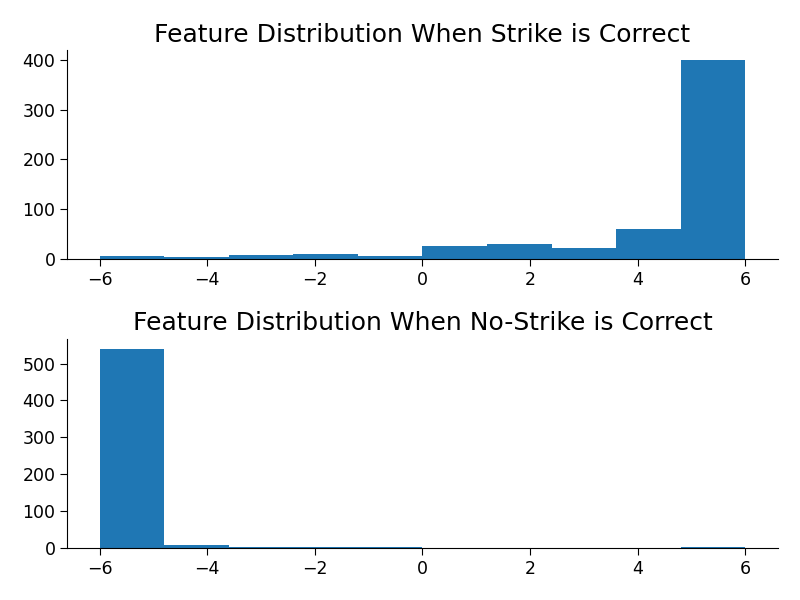

In [11]:
# and for scalar data always good to look at a histogram
fig, (ax1, ax2) = plt.subplots(2, 1)
remove_ip_clutter(fig)
ax1.hist(X_simple_1_feature[y1_simple.flatten() == 1])
ax1.set_title('Feature Distribution When Strike is Correct')
ax2.hist(X_simple_1_feature[y1_simple.flatten() == 0])
ax2.set_title('Feature Distribution When No-Strike is Correct')
plt.show()

Looking at the distribution of the input values across these two classes (strike vs. no-strike situations), we see that we should be able to correctly discriminate between these two cases most of the time. Perhaps the simplest decision rule that could be used in a situation like this is a 'threshold' decision rule. Looking at the histograms above, a good threshold would be one where the organism stirkes if the input value is above the threshold and does not strike if the input value is below the threshold. For now we leave aside how an organism might actually learn such a threshold from experience, and simply ask, what is the optimal such threhold value, given this particular set of $\text{input}, \text{output}$ pairs.

Let's use our perturb-measure-step optimization procedure to find the optimal threshold for discriminating between these two cases. A very low threshold means the predator strikes at everything, and a very high threshold means the predator strikes at nothing. The predator recieves a reward of one when it successfully strikes and a reward of negative one if it strikes when prey is not present. If it does not strike it recieves a reward of zero regardless of whether or not prey was present. Give these rewards, and the background prevalance of prey, and the two distributions of the feature when prey is present or absent what will the optimal threshold be

In [18]:
# @title Dialing in The Optimal Threshold

class InteractiveThresholdDialer:
  def __init__(self,
               features=X_simple_1_feature,
               labels=y1_simple):
    self.features = features
    self.labels = labels
    # maybe rewards have a slider ?
    self.correct_strike_r = 1
    self.false_strike_r = -1
    self.correct_non_strike_r = 0
    self.false_non_strike_r = 0
    self.bounds = [min(features)-0.5, max(features)+0.5]
    self.threshold_slider = widgets.FloatSlider(
        value=0, min=self.bounds[0], max=self.bounds[1], step=0.1,
        description='Threshold:', readout=True, readout_format='.2f')
    self.fig, (self.hist_ax, self.r_ax) = plt.subplots(2, 1, figsize=(8, 6),
                                                       sharex=True)
    self.init_plot()
    self.narration_display = widgets.Output()
    print("We have narration display", hasattr(self, 'narration_display'))
    remove_ip_clutter(self.fig)

    # Arrange widgets in a layout
    self.ui = widgets.VBox([
        widgets.HBox([self.fig.canvas,]),
        widgets.HBox([self.threshold_slider, self.narration_display])
    ])
    self.threshold_slider.observe(self.on_threshold_slider_changed, 'value')

  def eval_threshold(self, t):
    t = np.asarray(t).reshape(1, -1)  # 1 x len(t)
    features = self.features.reshape(-1, 1)  # len(features) x 1
    labels = self.labels.reshape(-1, 1)  # len(labels) x 1
    strikes = features > t # len(features) x len(t)
    non_strikes = features <= t # len(feature) x len(t)
    should_strike = labels == 1 # len(labels) x 1
    should_not_strike = labels == 0 #len(labels) x 1

    correct_strikes = strikes & should_strike #len(labels/features) x len(t)
    false_strikes = strikes & should_not_strike #len(labels/features) x len(t)
    correct_non_strikes = non_strikes & should_not_strike #len(labels/features) x len(t)
    false_non_strikes = non_strikes & should_strike #len(labels/features) x len(t)

    r = (self.correct_strike_r * np.sum(correct_strikes, axis=0) +
         self.false_strike_r * np.sum(false_strikes, axis=0) +
         self.correct_non_strike_r * np.sum(correct_non_strikes, axis=0) +
         self.false_non_strike_r * np.sum(false_non_strikes, axis=0))
    r = r.flatten()
    if len(r) == 1:
      r = r[0]
      # for single threshold evaluations
      num_correct_strikes = np.sum(correct_strikes)
      num_false_strikes = np.sum(false_strikes)
      num_correct_non_strikes = np.sum(correct_non_strikes)
      num_false_non_strikes = np.sum(false_non_strikes)
      # Prepare a text-based confusion matrix
      confusion_matrix_text = f"Confusion Matrix:\n"
      confusion_matrix_text += f"{'':<20} {'Predicted Strike':<17} {'Predicted Non-Strike':<20}\n"
      confusion_matrix_text += f"Actual Strike{'':<10} {num_correct_strikes:<17} {num_false_non_strikes:<20}\n"
      confusion_matrix_text += f"Actual Non-Strike{'':<4} {num_false_strikes:<17} {num_correct_non_strikes:<20}\n\n"
      confusion_matrix_text += f"Total Reward: {r}"
      self.narration_display.clear_output(wait=True)
      with self.narration_display:
        print(confusion_matrix_text)
    return r

  def on_threshold_slider_changed(self, change):
    self.plot_threshold(self.threshold_slider.value)
    self.fig.canvas.draw_idle()

  def plot_threshold(self, t):
    r = self.eval_threshold(t)
    self.threshold_vline.set_data([t, t], [0, r])
    y_min, y_max = self.hist_ax.get_ylim()
    self.hist_vline.set_data([t, t], [y_min, y_max])

  def init_plot(self):
    """Initialize the plot with placeholder data."""
    t_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    r_vals = self.eval_threshold(t_vals)
    # Initial plot commands return line objects, keep references to them
    self.threshold_vline, = self.r_ax.plot([],[] ,color='r', linestyle='--', label='Threshold')
    self.hist_vline, = self.hist_ax.plot([], [], color='r', linestyle='--', label='Threshold')
    self.reward_curve, = self.r_ax.plot(t_vals, r_vals, alpha=1.0, label='Expected Reward')
    self.hist_ax.hist(self.features[self.labels.flatten() == 1], alpha=0.5, label='Strike')
    self.hist_ax.hist(self.features[self.labels.flatten() == 0], alpha=0.5, label='No Strike')
    self.hist_ax.set_xlabel('Feature Value')
    self.hist_ax.set_ylabel('Counts')

    self.fig.suptitle('Threshold Evaluation')
    self.r_ax.set_xlabel('Threshold')
    self.r_ax.set_ylabel('Total Reward\n(Over 1125 trials)')
    self.plot_threshold(self.threshold_slider.value)
    self.hist_ax.legend()
    self.r_ax.legend()
    self.fig.canvas.draw_idle()



itd = InteractiveThresholdDialer()
display(itd.fig.canvas)
clear_output()
display(itd.ui)

Using narration_display False


AttributeError: 'InteractiveThresholdDialer' object has no attribute 'narration_display'

In [13]:
# @title Optimal Stike-No-Stike Threshold with Perturb-Measure-Step
# @markdown **Run this cell** to step through finding the optimal strike-no-stike threshold our perturb-measure-step approach.
class InteractiveThresholdSlopeStepper:
  def __init__(self,
               features=X_simple_1_feature,
               labels=y1_simple,
               test_size=0.1,
               step_size=0.2,
               adjustable_step_size=False,
               seed=None):
    self.features = features
    self.labels = labels
    # maybe rewards have a slider ?
    self.correct_strike_r = 1
    self.false_strike_r = -1
    self.correct_non_strike_r = 0
    self.false_non_strike_r = 0
    self.bounds = [min(features)-0.5, max(features)+0.5]
    self.test_step_slider = widgets.FloatSlider(
        value=test_size, min=-1.5, max=1.5, step=0.1,
        description='Test Step:', readout=True, readout_format='.2f')
    self.t_step_slider = widgets.FloatSlider(
        value=step_size, min=0.005, max=0.5, step=0.005,
        description='t Step:', readout=True, readout_format='.2f')
    self.adjustable_step_size = adjustable_step_size
    self.rng = np.random.default_rng(seed)
    self.current_t = self.rng.uniform(self.bounds[0], self.bounds[1])[0]
    self.current_r = self.eval_threshold(self.current_t)
    self.test_t = None
    self.test_r = None
    self.step_t = None
    self.step_r = None
    self.t_history = []
    self.r_history = []
    self.points_tested = 0
    self.fig, self.ax = plt.subplots(figsize=(6, 4))

    self.perturb = widgets.Button(description='Perturb')
    self.measure = widgets.Button(description='Measure')
    self.measure.disabled = True
    self.step = widgets.Button(description='Step')
    self.step.disabled = True

    self.reset = widgets.Button(description='Reset')
    self.show_history = widgets.ToggleButton(value=True, description='Show History')
    self.show_curve = widgets.ToggleButton(value=True, description='Show Curve')
    self.init_plot()
    self.narration_display = widgets.Output()
    remove_ip_clutter(self.fig)

    # Arrange widgets in a layout
    if self.adjustable_step_size:
      buttons_layout = widgets.VBox([
        widgets.HBox([self.perturb, self.measure, self.step]),
        self.test_step_slider,
        self.t_step_slider,
        widgets.HBox([self.reset, self.show_history])])
    else:
      buttons_layout = widgets.VBox([
        widgets.HBox([self.perturb, self.measure, self.step]),
        widgets.HBox([self.reset, self.show_history, self.show_curve])])
    buttons_and_narration = widgets.HBox([buttons_layout, self.narration_display])
    self.ui = widgets.VBox([self.fig.canvas, buttons_and_narration])

    #bind actions to handlers
    self.perturb.on_click(self.on_perturb_clicked)
    self.measure.on_click(self.on_measure_clicked)
    self.step.on_click(self.on_step_clicked)
    self.reset.on_click(self.on_reset_clicked)
    self.show_curve.observe(self.on_show_curve_toggled, 'value')
    self.show_history.observe(self.on_show_history_toggled, 'value')
    self.t_step_slider.observe(self.on_t_step_slider_changed, 'value')
    self.test_step_slider.observe(self.on_test_step_slider_changed, 'value')

  def eval_threshold(self, t):
    t = np.asarray(t).reshape(1, -1)  # 1 x len(t)
    features = self.features.reshape(-1, 1)  # len(features) x 1
    labels = self.labels.reshape(-1, 1)  # len(labels) x 1
    strikes = features > t # len(features) x len(t)
    non_strikes = features <= t # len(feature) x len(t)
    should_strike = labels == 1 # len(labels) x 1
    should_not_strike = labels == 0 #len(labels) x 1

    correct_strikes = strikes & should_strike #len(labels/features) x len(t)
    false_strikes = strikes & should_not_strike #len(labels/features) x len(t)
    correct_non_strikes = non_strikes & should_not_strike #len(labels/features) x len(t)
    false_non_strikes = non_strikes & should_strike #len(labels/features) x len(t)

    r = (self.correct_strike_r * np.sum(correct_strikes, axis=0) +
         self.false_strike_r * np.sum(false_strikes, axis=0) +
         self.correct_non_strike_r * np.sum(correct_non_strikes, axis=0) +
         self.false_non_strike_r * np.sum(false_non_strikes, axis=0))
    r = r.flatten()
    if len(r) == 1:
      r = r[0]
    return r

  def on_t_step_slider_changed(self, change):
    self.step_t = self.current_t + self.t_step_slider.value * self.slope
    self.step_r = self.slope * self.step_t + self.y_intercept
    self.step_point.set_data([self.step_t], [self.step_r])
    y_min, y_max = self.ax.get_ylim()
    self.step_vline.set_data([self.step_t, self.step_t], [y_min, self.step_r])
    self.fig.canvas.draw_idle()

  def on_test_step_slider_changed(self, change):
    if self.test_step_slider.value == 0:
      # Set to a default non-zero value
      self.test_step_slider.value = 0.01
      with self.narration_display:
        print(f"Test step size of 0 cannot be used to calculate slope. Using 0.01 to avoid division by zero in slope calculation.")
    self.test_t = self.current_t + self.test_step_slider.value
    self.test_r = self.eval_threshold(self.test_t)
    self.test_point.set_data([self.test_t], [self.test_r])
    if self.step_t is not None:
      rise = self.test_r - self.current_r
      run = self.test_t - self.current_t
      self.slope = rise / run
      self.y_intercept = self.current_r - self.slope * self.current_t
      t_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
      r_vals = self.slope * t_vals + self.y_intercept
      self.step_line.set_data(t_vals, r_vals)
      self.step_t = self.current_t + self.t_step_slider.value * self.slope
      self.step_r = self.slope * self.step_t + self.y_intercept
      self.step_point.set_data([self.step_t], [self.step_r])
      y_min, y_max = self.ax.get_ylim()
      self.step_vline.set_data([self.step_t, self.step_r], [y_min, self.step_r])
    self.fig.canvas.draw_idle()

  def init_plot(self):
    """Initialize the plot with placeholder data."""
    t_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    r_vals = self.eval_threshold(t_vals)
    # Initial plot commands return line objects, keep references to them
    self.point_current, = self.ax.plot([self.current_t], [self.current_r], 'bo', label='Current')
    self.test_point, = self.ax.plot([], [], 'rx', label='Test Point')  # Empty data to start
    self.step_point, = self.ax.plot([], [], 'go', label='Step Point')  # Empty data to start
    self.points_history, = self.ax.plot([], [], 'ks', alpha=0.5, label='History')  # Empty data to start
    self.line_polynomial, = self.ax.plot(t_vals, r_vals, alpha=1.0, label='Polynomial Curve')
    self.slope = 0
    self.y_intercept = self.current_r - self.slope * self.current_t
    self.step_line, = self.ax.plot([], [], 'r', label='Measure')
    self.step_vline, = self.ax.plot([], [], 'g', linestyle='--')
    self.ax.set_title('Threshold Evaluation')
    self.ax.set_xlabel('Threshold')
    self.ax.set_ylabel('Total Reward\n(Over 1125 trials)')
    self.ax.legend()
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_perturb_clicked(self, button):
    self.points_tested += 1
    self.test_t = self.current_t + self.test_step_slider.value
    self.test_r = self.eval_threshold(self.test_t)
    self.test_point.set_data([self.test_t], [self.test_r])
    self.fig.canvas.draw_idle()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Test t: {self.test_t:.3f}, y: {self.test_r:.3f}.')
      print(f'Current t: {self.current_t:.3f}, r: {self.current_r:.3f}.')
      print("Click measure to evaluate the slope based on this test point")
    self.measure.disabled = False
    self.perturb.disabled = True

  def on_measure_clicked(self, button):
    rise = self.test_r - self.current_r
    run = self.test_t - self.current_t
    self.slope = rise / run
    self.y_intercept = self.current_r - self.slope * self.current_t
    t_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    r_vals = self.slope * t_vals + self.y_intercept
    self.step_line.set_data(t_vals, r_vals)
    self.step_t = self.current_t + self.t_step_slider.value * self.slope
    self.step_r = self.slope * self.step_t + self.y_intercept
    self.step_point.set_data([self.step_t], [self.step_r])
    y_min, y_max = self.ax.get_ylim()
    self.step_vline.set_data([self.step_t, self.step_t], [y_min, self.step_r])
    self.fig.canvas.draw_idle()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Based on slope measurement proposed step from {self.current_t:.3f} to {self.step_t:.3f}')
      print("Click step, to make the step.")

    self.step.disabled = False
    self.measure.disabled = True

  def on_step_clicked(self, button):
    new_r = self.eval_threshold(self.step_t)
    with self.narration_display:
      clear_output(wait=True)
      print(f'Stepped to t: {self.step_t:.3f}')
      print(f'Actual reward for this threshold is {new_r:.3f}')
      print(f'Click perturb to test a new threshold.')
    self.t_history.append(self.current_t)
    self.r_history.append(self.current_r)
    self.points_history.set_data(self.t_history, self.r_history)
    self.current_t = self.step_t
    self.current_r = new_r
    self.point_current.set_data([self.current_t], [self.current_r])
    self.test_t = None
    self.test_r = None
    self.test_point.set_data([], [])
    self.step_t = None
    self.step_r = None
    self.step_point.set_data([], [])
    self.step_line.set_data([], [])
    self.step_vline.set_data([], [])
    self.fig.canvas.draw_idle()
    self.step.disabled = True
    self.perturb.disabled = False

  def on_reset_clicked(self, button):
    self.proposals_evaluated = 0
    with self.narration_display:
      clear_output(wait=True)
      print(f'Reset. Clearing history')
      print(f'Still using the same features and labels though')
    self.current_t = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.current_r = self.eval_threshold(self.current_x)
    self.test_t = None
    self.test_r = None
    self.step_t = None
    self.step_r = None
    self.t_history = []
    self.r_history = []
    self.step.disabled = True
    self.perturb.disabled = False
    self.point_current.set_data([self.current_t], [self.current_r])
    self.points_history.set_data(self.t_history, self.r_history)
    self.test_point.set_data([], [])
    self.step_point.set_data([], [])
    self.fig.canvas.draw_idle()

  def on_show_curve_toggled(self, change):
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_show_history_toggled(self, change):
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()



itss = InteractiveThresholdSlopeStepper()
display(itss.fig.canvas)
clear_output()
display(itss.ui)

This likely isn't working very well for you. The reason for this is that unlike the polynomial we first worked with, this threshold based striking policy does not change smoothly in the average rewards. It is a step function with whole ranges of threshold values resulting in the same average reward. There are ways of smoothing out such functions, but for now let's see if we can salvage our perturb-measure-step approach by taking perturbations that are big enough to step outside of the flat bits.

In [14]:
itssv = InteractiveThresholdSlopeStepper(adjustable_step_size=True)
display(itssv.fig.canvas)
clear_output()
display(itssv.ui)

So here we have a bit of an issue. To overcome the flat step-wise nature of the payoff function and make any progress we have to take big test steps, but big test steps ultimately limit how precisely we can dial in the actual optimal threshold value. This sort of fragility and fiddlyness is something that can be overcome, either by having test and parameter step sizes vary to match the scale of the reward function, in particular it's step widths, or as we will see

# 2.1.1.3 Optimal Striking Probability
A recurring and important idea in robust optimization processes is using randomness to a avoid and skirt over mathematical analytical difficulties that often arise as edge cases in fully deterministic processes. When using our perturb-measure-step process to optimize the total reward (given the specific set of features and data in our training set) when using a deterministic threshold rule we ran into one such issue. Reward for a threshold rule was a staircase function and so our perturb and measure process ran into issues, specifically the slope was estimated (correctly) as zero in many places, which was uninformative for parameter updates(Note that for small proposal step sizes relative to stair-step width of the $r(t)$ function our propose and reject algorithm will have similar issues. So now instead of a deterministic threshold, we are going to give our lurk and strike predator a probabalistic policy, one where it's probability of striking or not is determined as a function of the feature value. Then the reward will be a random variable, and the goal will be to find parameters for this probabilistic behaviour function such that the expected reward is as high as possible given the structure of the function, and the training data-set.

***Note on Terminology:*** In a Supervised Learning context what we have been thinking of as the inputs to a sensory-behaviour circuit are called **features**. In a statistical/regression/experimental context these features or inputs are thought of as the independent variables or regressors. The 'correct' behavioural output is called the **label** or **target** in a supervised learning ML context, or the dependent variable in a statistical/regression/experimental context. Supervised Learning revolves around the concept of feature-label or $(\mathbf{x},\mathbf{y})$ pairs. The basic goal of Supervised Learning is to discover a rule or process, aka train a model, that makes a good prediction of $\mathbf{y}$ given knowledge of it's associated $\mathbf{x}$, solely by examining examples. The set of examples that we have to learn this prediction rule from is called the **training set**. We will use the terms features and label when we want to emphasize the abstract algorithm and learning problem, and the terms sensory-input and target behaviour when we want to emphasize the embodied neural context of the problem.

As inspiration for our learning algorithm we imagine a very simple organism. One that has a single sensory input neuron, in turn connected to a single output neuron by single synaptic weight. If the output neuron fires (spikes) the predator strikes, and if it does not fire the predator does not strike.

We model this creature's sensory-behaviour system as follows. Let $x$ be the raw sensory input (scalar) in a given episode. We imagine that $x$ corresponds to the activation level and firing rate of a single photosensitive neuron. This input neuron is then connected by a synapse to a single output neuron. The activation level of this output neuron is computed as
$$y = wx + b$$
Here, $b$ is the (scalar) bias, or baseline activation level of the output neuron and $w$ is the strength of the synaptic weight between the input neuron and the output neuron. Is this case there is only one output and one input so $w$ is a scalar. In cases with multiple inputs and outputs we would use $\mathbf{W}$ to denote the matrix of such synaptic weights and $\mathbf{x}$ to denote the vector of sensory inputs. (A quick notation reminder: bold lowercase letters typically represent column vectors, bold uppercase letters typically denote matrices or higher-order tensors.) We imagine that the probabilistic spiking of this output neuron determines the strike-no-strike behaviour of the organism, specifically:
$$ \Pr \{\text{strike}\} = \sigma(y) $$
$$ \Pr \{\text{no strike}\} = 1 - \sigma(y)$$

Here $\sigma(y): \frac{1}{1+e^{-y}} = \frac{e^y}{1+e^y}$ is the standard logistic (sigmoid) function.

--Picture of this very simple neural circuit here--

**Quick Math Exercise: The Connection Between Softmax Normalization and the Standard Logistic Sigmoid.**

Consider a random variable with two possible outcomes, $A$ and $B$. The probability of each outcome is determined by applying the softmax function to their respective scores, $a$ and $b$. Specifically, the probability of outcome $A$ occurring is given by the softmax formula:
$$ \Pr \{A\} = \frac{e^a}{e^a + e^b}$$
Interestingly, $\Pr\{A\}$ can be expressed in terms of the logistic (sigmoid) function, $\sigma(x)$, where $x$ is a function of the scores $a$ and $b$. Your task is to determine this function, denoted as $f(a, b)$, so that $\Pr{A} = \sigma(f(a, b))$.

(Answer: $$\frac{e^a}{e^a + e^b} = \frac{1}{1 + e^{b-a}} = \sigma(a-b)$$
The sigmoid of the difference in the scores gives the probability.)

Having established how behaviour is determined by sensory input, $x$, and parameters $w$, $b$, i.e. our policy, let's see how our perturb-measure-step process works on this functio. There's just one wrinkle, now we have two parameters to optimize, not just one. Visualization is a little trickier but still possible, using a countour plot.



In [15]:
# @title Optimal Stike-No-Stike policy parameters, $w$ and $b$, with Perturb-Measure-Step
# @markdown **Run this cell** to step through finding the optimal strike-no-stike policy params using our perturb-measure-step approach.
class InteractiveThresholdSlopeStepper:
  def __init__(self,
               features=X_simple_1_feature,
               labels=y1_simple,
               test_size=0.1,
               step_size=0.2,
               adjustable_step_size=False,
               seed=None):
    self.features = features
    self.labels = labels
    # maybe rewards have a slider ?
    self.correct_strike_r = 1
    self.false_strike_r = -1
    self.correct_non_strike_r = 0
    self.false_non_strike_r = 0
    self.bounds = [min(features)-0.5, max(features)+0.5]
    self.test_step_slider = widgets.FloatSlider(
        value=test_size, min=-1.5, max=1.5, step=0.1,
        description='Test Step:', readout=True, readout_format='.2f')
    self.param_step_slider = widgets.FloatSlider(
        value=step_size, min=0.005, max=0.5, step=0.005,
        description='Param Step:', readout=True, readout_format='.2f')
    self.adjustable_step_size = adjustable_step_size
    self.rng = np.random.default_rng(seed)
    self.current_b = 0
    self.current_w = 0
    self.current_r = self.eval_wb(self.current_w, self.current_b)
    self.test_b = None
    self.test_w = None
    self.test_r = None
    self.step_b = None
    self.step_w = None
    self.step_r = None
    self.b_history = []
    self.w_history = []
    self.r_history = []
    self.points_tested = 0
    self.countour_fig, self.countour_ax = plt.subplots(figsize=(6, 4))
    self.fix_b_fig, self.fix_b_ax = plt.subplots(figsize=(6, 4))
    self.fix_w_fig, self.fix_w_ax = plt.subplots(figsize=(6, 4))
    self.perturb_b = widgets.Button(description='Perturb b')
    self.perturb_w = widgets.Button(description='Perturb w')
    self.measure_b = widgets.Button(description='Measure b')
    self.measure_w = widgets.Button(description='Measure w')
    self.measure_b.disabled = True
    self.measure_w.disabled = True
    self.step_b = widgets.Button(description='Step b')
    self.step_w = widgets.Button(description='Step w')
    self.step_b.disabled = True
    self.step_w.disabled = True

    self.reset = widgets.Button(description='Reset')
    self.show_history = widgets.ToggleButton(value=True, description='Show History')
    self.show_curve = widgets.ToggleButton(value=True, description='Show Curve')
    self.init_plot()
    self.narration_display = widgets.Output()
    remove_ip_clutter(self.countour_fig)
    remove_ip_clutter(self.fix_b_fig)
    remove_ip_clutter(self.fix_w_fig)

    # Arrange widgets in a layout
    if self.adjustable_step_size:
      buttons_layout = widgets.VBox([
        widgets.HBox([self.perturb, self.measure, self.step]),
        self.test_step_slider,
        self.t_step_slider,
        widgets.HBox([self.reset, self.show_history])])
    else:
      buttons_layout = widgets.VBox([
        widgets.HBox([self.perturb, self.measure, self.step]),
        widgets.HBox([self.reset, self.show_history, self.show_curve])])
    buttons_and_narration = widgets.HBox([buttons_layout, self.narration_display])
    self.ui = widgets.VBox([
        widgets.HBox([self.fix_b_fig.canvas, self.fix_w_fig.canvas]),
        widgets.HBox([buttons_and_narration, self.countour_fig.canvas])])

    #bind actions to handlers
    self.perturb_b.on_click(self.on_perturb_clicked)
    self.perturb_w.on_click(self.on_perturb_clicked)
    self.measure_b.on_click(self.on_measure_clicked)
    self.measure_w.on_click(self.on_measure_clicked)
    self.step_b.on_click(self.on_step_clicked)
    self.step_w.on_click(self.on_step_clicked)
    self.reset.on_click(self.on_reset_clicked)
    self.show_curve.observe(self.on_show_curve_toggled, 'value')
    self.show_history.observe(self.on_show_history_toggled, 'value')
    self.param_step_slider.observe(self.on_param_step_slider_changed, 'value')
    self.test_step_slider.observe(self.on_test_step_slider_changed, 'value')

  def sigmoid(self, x):
    return np.exp(x) / (np.exp(x) + 1)

  def eval_wb(self, w, b):
    strike_scores = np.flatten(w * self.features + b)
    strike_probs = self.sigmoid(strike_scores)
    should_strike = np.flatten(self.labels == 1)
    should_not_strike = np.flatten(self.labels == 0)
    exp_strike_r = (strike_probs[should_strike] * self.correct_strike_r +
                    strike_probs[should_not_strike] * self.false_strike_r)
    exp_non_strike_r = (1 - strike_probs[should_not_strike] * self.correct_non_strike_r +
                        1 - strike_probs[should_strike] * self.false_non_strike_r)

    return exp_strike_r
    correct_strikes = strikes & should_strike #len(labels/features) x len(t)
    false_strikes = strikes & should_not_strike #len(labels/features) x len(t)
    correct_non_strikes = non_strikes & should_not_strike #len(labels/features) x len(t)
    false_non_strikes = non_strikes & should_strike #len(labels/features) x len(t)

    r = (self.correct_strike_r * np.sum(correct_strikes, axis=0) +
         self.false_strike_r * np.sum(false_strikes, axis=0) +
         self.correct_non_strike_r * np.sum(correct_non_strikes, axis=0) +
         self.false_non_strike_r * np.sum(false_non_strikes, axis=0))
    r = r.flatten()
    if len(r) == 1:
      r = r[0]
    return r

  def on_t_step_slider_changed(self, change):
    self.step_t = self.current_t + self.t_step_slider.value * self.slope
    self.step_r = self.slope * self.step_t + self.y_intercept
    self.step_point.set_data([self.step_t], [self.step_r])
    y_min, y_max = self.ax.get_ylim()
    self.step_vline.set_data([self.step_t, self.step_t], [y_min, self.step_r])
    self.fig.canvas.draw_idle()

  def on_test_step_slider_changed(self, change):
    if self.test_step_slider.value == 0:
      # Set to a default non-zero value
      self.test_step_slider.value = 0.01
      with self.narration_display:
        print(f"Test step size of 0 cannot be used to calculate slope. Using 0.01 to avoid division by zero in slope calculation.")
    self.test_t = self.current_t + self.test_step_slider.value
    self.test_r = self.eval_threshold(self.test_t)
    self.test_point.set_data([self.test_t], [self.test_r])
    if self.step_t is not None:
      rise = self.test_r - self.current_r
      run = self.test_t - self.current_t
      self.slope = rise / run
      self.y_intercept = self.current_r - self.slope * self.current_t
      t_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
      r_vals = self.slope * t_vals + self.y_intercept
      self.step_line.set_data(t_vals, r_vals)
      self.step_t = self.current_t + self.t_step_slider.value * self.slope
      self.step_r = self.slope * self.step_t + self.y_intercept
      self.step_point.set_data([self.step_t], [self.step_r])
      y_min, y_max = self.ax.get_ylim()
      self.step_vline.set_data([self.step_t, self.step_r], [y_min, self.step_r])
    self.fig.canvas.draw_idle()

  def init_plot(self):
    """Initialize the plot with placeholder data."""
    t_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    r_vals = self.eval_threshold(t_vals)
    # Initial plot commands return line objects, keep references to them
    self.point_current, = self.ax.plot([self.current_t], [self.current_r], 'bo', label='Current')
    self.test_point, = self.ax.plot([], [], 'rx', label='Test Point')  # Empty data to start
    self.step_point, = self.ax.plot([], [], 'go', label='Step Point')  # Empty data to start
    self.points_history, = self.ax.plot([], [], 'ks', alpha=0.5, label='History')  # Empty data to start
    self.line_polynomial, = self.ax.plot(t_vals, r_vals, alpha=1.0, label='Polynomial Curve')
    self.slope = 0
    self.y_intercept = self.current_r - self.slope * self.current_t
    self.step_line, = self.ax.plot([], [], 'r', label='Measure')
    self.step_vline, = self.ax.plot([], [], 'g', linestyle='--')
    self.ax.set_title('Threshold Evaluation')
    self.ax.set_xlabel('Threshold')
    self.ax.set_ylabel('Total Reward\n(Over 1125 trials)')
    self.ax.legend()
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_perturb_clicked(self, button):
    self.points_tested += 1
    self.test_t = self.current_t + self.test_step_slider.value
    self.test_r = self.eval_threshold(self.test_t)
    self.test_point.set_data([self.test_t], [self.test_r])
    self.fig.canvas.draw_idle()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Test t: {self.test_t:.3f}, y: {self.test_r:.3f}.')
      print(f'Current t: {self.current_t:.3f}, r: {self.current_r:.3f}.')
      print("Click measure to evaluate the slope based on this test point")
    self.measure.disabled = False
    self.perturb.disabled = True

  def on_measure_clicked(self, button):
    rise = self.test_r - self.current_r
    run = self.test_t - self.current_t
    self.slope = rise / run
    self.y_intercept = self.current_r - self.slope * self.current_t
    t_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    r_vals = self.slope * t_vals + self.y_intercept
    self.step_line.set_data(t_vals, r_vals)
    self.step_t = self.current_t + self.t_step_slider.value * self.slope
    self.step_r = self.slope * self.step_t + self.y_intercept
    self.step_point.set_data([self.step_t], [self.step_r])
    y_min, y_max = self.ax.get_ylim()
    self.step_vline.set_data([self.step_t, self.step_t], [y_min, self.step_r])
    self.fig.canvas.draw_idle()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Based on slope measurement proposed step from {self.current_t:.3f} to {self.step_t:.3f}')
      print("Click step, to make the step.")

    self.step.disabled = False
    self.measure.disabled = True

  def on_step_clicked(self, button):
    new_r = self.eval_threshold(self.step_t)
    with self.narration_display:
      clear_output(wait=True)
      print(f'Stepped to t: {self.step_t:.3f}')
      print(f'Actual reward for this threshold is {new_r:.3f}')
      print(f'Click perturb to test a new threshold.')
    self.t_history.append(self.current_t)
    self.r_history.append(self.current_r)
    self.points_history.set_data(self.t_history, self.r_history)
    self.current_t = self.step_t
    self.current_r = new_r
    self.point_current.set_data([self.current_t], [self.current_r])
    self.test_t = None
    self.test_r = None
    self.test_point.set_data([], [])
    self.step_t = None
    self.step_r = None
    self.step_point.set_data([], [])
    self.step_line.set_data([], [])
    self.step_vline.set_data([], [])
    self.fig.canvas.draw_idle()
    self.step.disabled = True
    self.perturb.disabled = False

  def on_reset_clicked(self, button):
    self.proposals_evaluated = 0
    with self.narration_display:
      clear_output(wait=True)
      print(f'Reset. Clearing history')
      print(f'Still using the same features and labels though')
    self.current_t = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.current_r = self.eval_threshold(self.current_x)
    self.test_t = None
    self.test_r = None
    self.step_t = None
    self.step_r = None
    self.t_history = []
    self.r_history = []
    self.step.disabled = True
    self.perturb.disabled = False
    self.point_current.set_data([self.current_t], [self.current_r])
    self.points_history.set_data(self.t_history, self.r_history)
    self.test_point.set_data([], [])
    self.step_point.set_data([], [])
    self.fig.canvas.draw_idle()

  def on_show_curve_toggled(self, change):
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_show_history_toggled(self, change):
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()



itss = InteractiveThresholdSlopeStepper()
display(itss.fig.canvas)
clear_output()
display(itss.ui)

AttributeError: module 'numpy' has no attribute 'flatten'

Our goal is to come up with a rule that prescribes changes to the synaptic weight $w$ and bias $b$ in such a way that the reward obtained over time increases (and ideally approaches the theoretical maximum over many learning trials).

Our previous 'guess and check' learning method from sequence 1.3.4, while not the most efficient, proved effective, as were the 'propose and reject' style algorithms that we explored earlier and that are akin to what evolution by natural selection implements. Building on this idea of 'propose and reject' we will perturb the existing parameters by a small amount and evaluate the behaviour function using the perturbed parameters. However, instead of just simply accepting or rejecting the proposed parameters (kind of like natural selection does) we will instead ***measure the relationship between the change in the performance of the organism (in terms of reward obtained) and the changes in the parameters.*** An update will then be applied to the weights that is ***proportional*** to the ***measured performance changes*** over the ***measured parameter changes***, i.e. an estimate of the rate of change in performance for changes in the parameters. As a word equation

$$ \text{Parameter Update} = \alpha \cdot \frac{\text{Measured Perturbation in Performance}}{\text{Measured Perturbation in Parameters}}$$

where $\alpha$ is some constant of proportionality, in this case usually called the learning rate or step-size meta-parameter of the learning algorithm.

On the one hand we might expect a 'measure and update' method to be more efficient than a 'propose and reject' method, because with a 'propose and reject' algorithm we don't make any parameter updates unless 'better' parameters are proposed. This means that most of the information from evaluation is thrown away every time parameters are rejected. In contrast, a 'measure and update' method will always updated the parameters using the information gleaned from the tested parameters. However, unlike the 'propose and reject' algorithm it's possible that the updates made by a 'measure and update' approach do not actually improve performance.

Let's try it and see.

In [ ]:
################################################################################
# TODO for students: Complete the lines with ... to implement a parameter
# evaluation function
raise NotImplementedError("Exercise: parameter evaluation")
################################################################################


def np_sigmoid(x):
  return 1 / (1 + np.exp(-x))


def eval_params_slow(w, b, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use for loops to think carefully about what we're doing
  Args:
    w: (scalar) weight between sensory and output neuron
    b: (scalar) bias of behavioural output neuron
    x: (1 np.array x batch) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (1 np.array x batch) target behavioural output (can be a single target,
       mini-batch of targets, or whole batch), needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  batch_len = x.shape[1]
  h = np.zeros((1, batch_len))
  y_hat = np.zeros((1, batch_len))
  R_total = 0
  for ii in range(batch_len):
    h[0,ii] = ...
    y_hat[0,ii] = np_sigmoid(...)
    # y_hat is our probability of striking
    # compute the expected score
    if y[0,ii] == 1:
      # supposed to strike
      # with probability y_hat creature strikes and gets a point
      R_total += y_hat[0,ii] * 1.0
      # with probability 1-y_hat creature doesn't strike and gets zero points
      R_total += (1-y_hat[0,ii]) * 0.0
    elif y[0,ii] == 0:
      # not supposed to strike
      # with probability y_hat creature strikes and loses a point
      R_total += y_hat[0,ii] * -1.0
      # with probability 1-y_hat creature doesn't strike and gets zero points
      R_total += (1-y_hat[0,ii]) * 0.0
    else:
      raise ValueError(f'Unexpected target: {y[ii,0]}')
  R_avg = R_total / batch_len
  return R_avg


def eval_params(w, b, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    w: (scalar) weight between sensory and output neuron
    b: (scalar) bias of behavioural output neuron
    x: (batch x 1 np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (batch x 1 np.array) target behavioural output (can be a single target,
       mini-batch of targets, or whole batch), needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  h = w * x + b
  y_hat = np_sigmoid(h)
  y_score = np.copy(y)
  y_score[y_score == 0] = -1
  batch_expected_reward = y_score * y_hat
  R_avg = np.mean(batch_expected_reward)
  return R_avg

Now, if we were acting as scientists (which we sometimes do!), we'd think hard and carefully about the specific physical processes behind these features (the ML term for model/sensory inputs) and labels (the ML term for 'correct answer'), and this would guide the types of analyses to perform on the data and the kinds of inferences and conclusions we could draw.
But in this moment, we're not acting as scientists in pursuit of deep understanding; we're acting as algorithm designers focused on figuring out how to do the right thing. We want to come up with a process for 'learning a function' that takes this feature as an input and generates the correct behaviour (as defined by the labels) as output. A zero label means no strike is the right thing to do (no prey present) and a one label means striking is the right thing to do (prey are present).  

In [ ]:
# to_remove solution

def np_sigmoid(x):
  return 1 / (1 + np.exp(-x))


def eval_params_slow(w, b, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use for loops to think carefully about what we're doing
  Args:
    w: (scalar) weight between sensory and output neuron
    b: (scalar) bias of behavioural output neuron
    x: (1 np.array x batch) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (1 np.array x batch) target behavioural output (can be a single target,
       mini-batch of targets, or whole batch), needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  batch_len = x.shape[1]
  h = np.zeros((1, batch_len))
  y_hat = np.zeros((1, batch_len))
  R_total = 0
  for ii in range(batch_len):
    h[0,ii] = w * x[0,ii] + b
    y_hat[0,ii] = np_sigmoid(h[0,ii])
    # y_hat is our probability of striking
    # compute the expected score
    if y[0,ii] == 1:
      # supposed to strike
      # with probability y_hat creature strikes and gets a point
      R_total += y_hat[0,ii] * 1.0
      # with probability 1-y_hat creature doesn't strike and gets zero points
      R_total += (1-y_hat[0,ii]) * 0.0
    elif y[0,ii] == 0:
      # not supposed to strike
      # with probability y_hat creature strikes and loses a point
      R_total += y_hat[0,ii] * -1.0
      # with probability 1-y_hat creature doesn't strike and gets zero points
      R_total += (1-y_hat[0,ii]) * 0.0
    else:
      raise ValueError(f'Unexpected target: {y[ii,0]}')
  R_avg = R_total / batch_len
  return R_avg


def eval_params(w, b, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    w: (scalar) weight between sensory and output neuron
    b: (scalar) bias of behavioural output neuron
    x: (batch x 1 np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (batch x 1 np.array) target behavioural output (can be a single target,
       mini-batch of targets, or whole batch), needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  h = w * x + b
  y_hat = np_sigmoid(h)
  y_score = np.copy(y)
  y_score[y_score == 0] = -1
  batch_expected_reward = y_score * y_hat
  R_avg = np.mean(batch_expected_reward)
  return R_avg

In this exercise, we actually implemented the same function twice, once using a for loop to iterate over the (mini-)batch of inputs and targets, and once using NumPy broadcasting to compute the batch reward (roughly) in parallel. Run the following code cells to see what kind of computational efficiency this buys us.

In [ ]:
X_simple_1_feature.T.shape

In [ ]:
eval_params_slow(1, 0, X_simple_1_feature.T, y1_simple.T)

In [ ]:
eval_params(1, 0, X_simple_1_feature.T, y1_simple.T)

In [ ]:
%timeit eval_params_slow(1, 0, X_simple_1_feature.T, y1_simple.T)

In [ ]:
%timeit eval_params(1, 0, X_simple_1_feature.T, y1_simple.T)

In our specific example (on the specific COLAB instance we're writing this on in 2024), the broadcasting approach in Python, using NumPy, is approximately 50 times faster than using for-loops. This is because for-loops in interpreted languages like Python incur significant overhead at each iteration, but also because potential dependencies between loop iterations limit parallelization. In contrast, broadcasting allows for vectorized operations, enabling parallel execution that can harness more of the underlying hardware's computational power. NumPy enhances this efficiency further by utilizing highly optimized, pre-compiled linear algebra libraries (primarily hardware-specific implementations of BLAS and LAPACK). The same principles apply (though are sometimes less critical) in compiled languages or with Just-In-Time (JIT) compilation frameworks like JAX. Broadcasting or tensor notation not only improves performance but also maintains code brevity and alignment with mathematical notation. As scientists and programmers, we do not need to understand every detail of how the magic of computational parallelism allows for fast linear algebra, but it is crucial to appreciate the potential impacts on computational efficiency.

Okay, so we have the ability to evaluate the parameters in terms of the average score they yield when applied across the whole dataset of example pairs of sensory inputs and correct actions. In each iteration of our learning (training) loop, we will perturb our parameters using Gaussian noise and ***measure the relationship*** between the parameter changes and the average expected reward as determined by our evaluation function. After measuring this relationship, we will update each parameter in proportion to the rate of improvement of the score with respect to the change in the underlying parameter.

In [ ]:
# @title Measure and Update Training Loop

In [ ]:
################################################################################
# TODO for students: Complete the lines with ... to implement a parameter
# evalution function
raise NotImplementedError("Exercise: Measure and Update Training Loop")
################################################################################


learn_rng = np.random.default_rng(0)
num_learning_episodes = 100000
alpha = 100 #learning rate / step size
perturbation_scale = 0.01 # std of Gaussian parameter perturbations
w_init = 1
b_init = 0
w = w_init
b = b_init
start_time = time.time()
for ii in range(num_learning_episodes+1):
  R_bar_old = eval_params(w, b, X_simple_1_feature.T, y1_simple.T)
  # perturb w and evaluate
  w_perturbation = learn_rng.normal(0, perturbation_scale)
  w_perturbed = w + ...
  R_bar_perturbed_w = eval_params(..., b, X_simple_1_feature.T, y1_simple.T)
  # perturb b and evaluate
  b_perturbation = learn_rng.normal(0, perturbation_scale)
  b_perturbed = b + ...
  R_bar_perturbed_b = eval_params(..., b_perturbed, X_simple_1_feature, y1_simple)
  # estimate rate of change of reward for each parameter
  finite_difference_w = ...
  finite_difference_b = ...
  # update parameters based on finte difference estimate rate of change
  # of reward with respect to parameters
  delta_w = alpha * finite_difference_w
  delta_b = alpha * finite_difference_b
  w += delta_w
  b += delta_b

  if ii == 0 or ii % 5000 == 0:
    elapsed_time = time.time() - start_time
    print(f'{"Iteration":>12}: {ii:<6} | {"w":>1}={w:<8.4f} | {"b":>1}={b:<8.4f} | {"R_bar":>5}={R_bar_old:<8.6f} | {"Time":>4}={elapsed_time:<5.2f} seconds')

In [ ]:
# to_remove solution

learn_rng = np.random.default_rng(0)
num_learning_episodes = 100000
alpha = 100 #learning rate / step size
perturbation_scale = 0.01 # std of Gaussian parameter perturbations
w_init = 1
b_init = 0
w = w_init
b = b_init
start_time = time.time()
for ii in range(num_learning_episodes+1):
  R_bar_old = eval_params(w, b, X_simple_1_feature.T, y1_simple.T)
  # perturb w and evaluate
  w_perturbation = learn_rng.normal(0, perturbation_scale)
  w_perturbed = w + w_perturbation
  R_bar_perturbed_w = eval_params(w_perturbed, b, X_simple_1_feature.T, y1_simple.T)
  # perturb b and evaluate
  b_perturbation = learn_rng.normal(0, perturbation_scale)
  b_perturbed = b + b_perturbation
  R_bar_perturbed_b = eval_params(w, b_perturbed, X_simple_1_feature, y1_simple)
  # estimate rate of change of reward for each parameter
  finite_difference_w = (R_bar_perturbed_w - R_bar_old) / w_perturbation
  finite_difference_b = (R_bar_perturbed_b - R_bar_old) / b_perturbation
  # update parameters based on finte difference estimate rate of change
  # of reward with respect to parameters
  delta_w = alpha * finite_difference_w
  delta_b = alpha * finite_difference_b
  w += delta_w
  b += delta_b

  if ii == 0 or ii % 5000 == 0:
    elapsed_time = time.time() - start_time
    print(f'{"Iteration":>12}: {ii:<6} | {"w":>1}={w:<8.4f} | {"b":>1}={b:<8.4f} | {"R_bar":>5}={R_bar_old:<8.6f} | {"Time":>4}={elapsed_time:<5.2f} seconds')

Is an R_bar of 0.4951... good or bad? Let's look at the data. How many striking opportunities are there, versus situation where no-strike is best?

In [ ]:
# number of striking opportunities
np.sum(y1_simple == 1)

In [ ]:
#number of non-strike situations
np.sum(y1_simple == 0)

In [ ]:
# proportion of situations where a point can be earned
571 / (571 + 554)

So, back to our question: Is an average score of 0.4951... per round good? Well, yes. A perfect score is ~0.5075. Given that we have only a single feature - that can't perfectly separate the two cases as the feature distributions for each case overlap - we are bound to have a few false positives and false negatives. These will lower the score a bit, but for the most part, this is roughly as good as can be expected.

**Algorithmic Thinking Exercise:**

In the 'measure and update' learning loop implemented above, we perturb each parameter, measure the effect of perturbations, and then update the parameters. Alternatively we could have perturbed the $w$ parameter, evaluated and then updated the $w$ parameter, and then perturbed the $b$ parameter, evaluated, and then updated the $b$ parameter.
1. In the implementation above how many times is the `eval_params` function called per iteration?

  (Answer: 3)
2. If we used the alternative method where each parameter is updated and evaluated separately, how many times would eval_params need to be called per iteration?

  (Answer: 4, After updating $w$ we can't simply use `R_bar_old` to measure the change in performance from changing $b$ since `R_bar_perturbed_b` will be computed using the updated $w$. An `R_bar_new_w_old_b` will need to be computed and used to inform the changes to $b$.)
3. If we had $n$ parameters instead of 2, how many times would the `eval_params` function be called per iteration in the implementation above?

  (Answer: $n+1$)
4. If we had $n$ parameters instead of 2, how many times would the `eval_params` function be called per iteration in the alternate implementation?

  (Answer: $2n$)

Little details like this in implementation can make big differences to algorithm speed. Note though that this slower alternative isn't quite a dead loss. Technically the parameter updates made by the alternative algorithm, will be 'better' (precisely what we mean by better we leave aside for the moment), however, in this particular case the 'betterness' of the parameter updates is not enough to make up for the added computational cost of calling `eval_params` and extra $n-1$ times.

Okay, now just as a sanity and intuition check, two questions:
1. Do we get the same answer when we use a propose and reject method?  
2. Is the propose and reject method quicker or slower at finding the solution?
Let's quickly adapt the adapt 'measure and update' learning loop to do 'propose and reject' instead.

In [ ]:
# @title Propose And Reject Training Loop
learn_rng = np.random.default_rng(0)
num_learning_episodes = 50000
perturbation_scale = 0.1 # std of Gaussian parameter perturbations
w_init = 1
b_init = 0
w = w_init
b = b_init
start_time = time.time()  # Record the start time
R_bar_best = eval_params(w, b, X_simple_1_feature.T, y1_simple.T)
for ii in range(num_learning_episodes+1):
  # perturb w and evaluate
  w_perturbation = learn_rng.normal(0, perturbation_scale)
  w_proposed = w + w_perturbation
  R_bar_proposed = eval_params(w_proposed, b, X_simple_1_feature, y1_simple)
  if R_bar_best < R_bar_proposed:
    w = w_proposed
    R_bar_best = R_bar_proposed
  # perturb b and evaluate
  b_perturbation = learn_rng.normal(0, perturbation_scale)
  b_proposed = b + b_perturbation
  R_bar_proposed = eval_params(w, b_proposed, X_simple_1_feature, y1_simple)
  if R_bar_best < R_bar_proposed:
    b = b_proposed
    R_bar_best = R_bar_proposed

  if ii == 0 or ii % 5000 == 0:
    elapsed_time = time.time() - start_time
    print(f'{"Iteration":>12}: {ii:<6} | {"w":>1}={w:<8.4f} | {"b":>1}={b:<8.4f} | {"R_bar":>5}={R_bar_best:<8.6f} | {"Time":>4}={elapsed_time:<5.2f} seconds')

Both 'Propose and Reject' and 'Measure and Update' get to similar answers, but 'Propose and Reject' gets there much more quickly. In part, this is because there are fewer calls to `eval_params` per iteration (2 instead of 3). Additionally, this is because the step size in parameter space remains relatively constant throughout the 'Propose and Reject' process, while in the 'Measure and Update' method, the step size in parameter space diminishes as the relative improvements in performance decrease. For these reasons, our initial hope that 'Measure and Update' might be more efficient that 'Propose and Reject' is not born out in this simple problem.

-- animation of propose and reject versus measure and update in this simple 2 parameter problem --

A couple things to think about here:
1. In our 'Measure and Update' implementation above we make one perturbation and one measurement of change in reward for each parameter. What would happen if we perturbed every parameter at once and then made a single measurement of change in reward? There would only be two calls to `eval_params` per iteration, regardless of the number of parameters. Together these two `eval_params` would measure the combined effect of all the parameter changes on reward. As a result the estimated effect of any one parameter on the reward would be polluted by the effects of all the other parameter perturbations. Whether this improves or breaks the algorithm will depend on whether the efficiency from fewer `eval_params` calls compensate for the noise introduced, or if the noise make these faster parameter updates fundamentally unhelpful? In other words is it better to take more/quicker noisy steps in parameters space or fewer/slower steps in better directions?
2. In the learning loops above the impact on reward for a perturbation is measured using the entirety of the data set available to us. In this example the data set is only ~1000 examples, but what if it consisted of trillions of examples, would it still make sense to use the entire data set to evaluate each perturbation or would it be better to evaluate parameter changes using a smaller sample from this data set? Using a smaller sample will often make evaluations faster at the price of introducing noise to the estimate of rate of reward change (on the full data set) with respect to parameter changes. Again, this is question of more/quicker noisy steps or fewer/slower careful steps in parameters space.
3. In the learning loops above we measure the relationship between parameter changes and reward changes using a single perturbation, but could we make better parameter updates if we measured using many perturbations before updating the parameters? This would require making more evaluations per update. Whether is this is a good or bad idea again comes down to a question of more/quicker noisy parameter updates versus fewer/slower careful parameter updates. What is the right balance?

For this very straightforward problem these questions may seem kind of beside the point. We have a good answer, and it didn't take too long to get, why worry about these details now? We don't really need to now, but as we'll soon see, these details become increasingly relevant as we work to extend this 'measure and update' approach to a more complex problem. Indeed, the trade-off between more/quick noisy steps and few/slow careful steps is one of the fundamental questions at the dark heart of Machine Learning.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M1")

# 2.1.1.2: Learning to Do the Right Thing - Harder
In the previous section, we worked on a pretty simple discrimination problem, there was a single feature that, for the most part, correlated with correct times to strike and not-strike. Now we're going to look at a slightly harder problem, where the answer is less obvious (to us at least). As before, given a sensory input pattern, the problem is to determine whether or not to strike. Again, try to maximize your average score for this new problem where the 'sensory' input is more complex.

In [ ]:
scramble_bin_hard = InteractiveMNISTPredator(features=Xs,
                                             labels=y1,
                                             feedback_type='both')
display(scramble_bin_hard.fig.canvas)
clear_output()
display(scramble_bin_hard.ui)

So now instead of a single feature to base our strike/no-strike discrimination on, we have 64 (8x8) features to potentially inform our decision. Will our simple setup from before readily generalize to this situation with richer sensory input? Let's find out.

We model this creature's sensory-behaviour system much as before. Now, $\mathbf{x}$ is the raw sensory input (vector) in a given episode. Each element $x_i$ of $\mathbf{x}$ corresponds to the activation level and firing rate of a single photosensitive neuron.

In [ ]:
# the data set we're working with has 5620 example sensory inputs,
# each consisting of 64 (8x8) values
print(Xs.shape)

In [ ]:
# this is the first example
print(Xs[0].reshape(8,8,))

In [ ]:
# visualizing the example we see that lower values correspond to darker pixels
# and higher values correspond to lighter values
fig, ax = plt.subplots(figsize=(4,4))
remove_ip_clutter(fig)
ax.imshow(Xs[0].reshape(8,8), cmap='gray')
plt.show()

These input neurons are then connected by synapses to a single output neuron. The activation level of this output neuron is computed as
$$y = \mathbf{Wx} + b$$
Here, $b$ is the (scalar) bias, or baseline activation level of the output neuron, and $\mathbf{W}$ is a matrix of synaptic weights between the input neurons and the single output neuron. (In this case where there is only one output neuron so $\mathbf{W}$ has shape 1x64 so could also be thought of as a row vector.)  As before, the probabilistic spiking of this output neuron determines the strike-no-strike behaviour of the organism, specifically:
$$ \Pr \{\text{strike}\} = \sigma(y) $$
$$ \Pr \{\text{no strike}\} = 1 - \sigma(y)$$

Recall that $\sigma(y): \frac{1}{1+e^{-y}} = \frac{e^y}{1+e^y}$ is the standard logistic (sigmoid) function.

In [ ]:
# the eval_params function needs to be adapted
# to work with this richer sensory input
def eval_params_rich(W, b, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(1) x inputs(64) np.array)
       weights between sensory neurons and output neuron
    b: (scalar) bias of behavioural output neuron
    x: (input(64) x batch np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (outputs(1) x batch np.array) target behavioural output
       (can be a single target, mini-batch of targets, or whole batch),
       needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  h = np.dot(W,x) + b # 1 x batch
  y_hat = np_sigmoid(h) # 1 x batch
  y_score = np.copy(y)
  y_score[y_score == 0] = -1
  batch_expected_reward = y_score * y_hat
  R_bar = np.mean(batch_expected_reward)
  return R_bar

In [ ]:
eval_params_rich(np.ones((1,64)), 0, Xs.T, y1.T)

In [ ]:
%timeit eval_params_rich(np.ones((1,64)), 0, Xs.T, y1.T)

That's working and relatively quick now let's adapt our learning loop for this new setup.

In [ ]:
# @title Measure and Update Training Loop

learn_rng = np.random.default_rng(0)
num_learning_episodes = 2000
alpha = 0.5 #learning rate or step size
perturbation_scale = 0.001 # std of gaussian perturbations
W_init = np.zeros((1,64))
b_init = 0
W = W_init
b = b_init
start_time = time.time()
for ii in range(num_learning_episodes+1):
  R_bar_old = eval_params_rich(W, b, Xs.T, y1.T)
  # get perturbations for W all at once
  W_perturbations = learn_rng.normal(0, perturbation_scale, size=(1,64))
  #perturb and evaluate each W_j separately
  finite_differences_W = np.zeros(W.shape)
  for j in range(W_perturbations.shape[1]):
    W_perturbed = np.copy(W)
    W_perturbed[0,j] += W_perturbations[0,j]
    R_bar_perturbed_Wj = eval_params_rich(W_perturbed, b, Xs.T, y1.T)
    finite_difference_Wj = (R_bar_perturbed_Wj - R_bar_old) / W_perturbations[0,j]
    finite_differences_W[0,j] = finite_difference_Wj
  # perturb b and evaluate
  b_perturbation = learn_rng.normal(0, perturbation_scale)
  b_perturbed = b + b_perturbation
  R_bar_perturbed_b = eval_params_rich(W, b_perturbed, Xs.T, y1.T)
  # estimate rate of change of reward for each parameter
  finite_difference_b = (R_bar_perturbed_b - R_bar_old) / b_perturbation
  # update parameters based on finte difference estimate rate of change
  # of reward with respect to parameters
  delta_W = alpha * finite_differences_W
  delta_b = alpha * finite_difference_b
  W += delta_W
  b += delta_b

  if ii == 0 or ii % 100 == 0:
    elapsed_time = time.time() - start_time
    print(f'{"Iteration":>12}: {ii:<6} | {"W_0":>1}={W[0,0]:<8.4f} | {"b":>1}={b:<8.4f} | {"R_bar":>5}={R_bar_old:<8.6f} | {"Time":>4}={elapsed_time:<5.2f} seconds')

So it looks like this is learning to do an okay job. A quick inspection of the data tells us that doing perfect discrimination would give an average score of 0.503... per round.



In [ ]:
# There are this many cases where striking is the right thing to do
np.sum(y1 == 1)

In [ ]:
# And this many cases where striking is the wrong thing to do
np.sum(y1 == 0)

In [ ]:
# So this the average score per round with perfect discrimination
np.sum(y1 == 1) / (len(y1))

Without benchmarks, it's hard to know what level is possible given this particular dataset and discrimination task using this particular sensory-behaviour circuit. Not only are we unsure if this is a good result in a general sense, but we also don't know whether our less-than-perfect performance is due to limitations of the circuit architecture (the model in ML terms) or our learning algorithm's inability to find optimal parameters for the given architecture. We could always let the above learning process run for a really long time and see where it stops, but who wants to wait around for results, not us. Let's see if we can come up with some faster learning processes for this sensory-behaviour circuit.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M2")

# 2.1.1.3: Learning to Do the Right Thing - Faster

In our simple problem 'propose and reject' was quite effective, let's see how it fares in this more complex problem. First, though, to make our programming and notation a little cleaner we are going 'hide' our bias term. We to do this by augmenting the features to include a feature that always has the value '1'. Then, the 'weight' associated with this feature, which always has a value of '1', will effectively serve as the bias term.

In [ ]:
# Before augmentation this is the shape of the feature set
Xs.shape

In [ ]:
# After augmentation there is one extra column of features
Xs_aug = np.hstack([Xs, np.ones((Xs.shape[0],1))])
print(Xs_aug.shape)

In [ ]:
# We need to tweak our eval_params function to work with this augmented
# feature set

def eval_params_aug(W, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(1) x inputs(64) np.array)
       weights between sensory neurons and output neuron
    x: (input(64) x batch np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (outputs(1) x batch np.array) target behavioural output
       (can be a single target, mini-batch of targets, or whole batch),
       needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  h = np.dot(W,x) # 1 x batch
  y_hat = np_sigmoid(h) # 1 x batch
  y_score = np.copy(y)
  y_score[y_score == 0] = -1
  batch_expected_reward = y_score * y_hat
  R_bar = np.mean(batch_expected_reward)
  return R_bar

This is what 'propose and reject' looks like for this harder problem:

In [ ]:
# @title Propose and Reject Training Loop
learn_rng = np.random.default_rng(0)
num_learning_episodes = 2000
perturbation_scale = 0.1 # std of gaussian perturbations
W_init = np.zeros((1,65))
W = W_init
start_time = time.time()
R_bar_best = eval_params_aug(W, Xs_aug.T, y1.T)
for ii in range(num_learning_episodes+1):
  W_perturbations = learn_rng.normal(0, perturbation_scale, size=(1,65))
  #perturb and evaluate each W_j separately
  finite_differences_W = np.zeros(W.shape)
  for j in range(W_perturbations.shape[1]):
    #perturb W
    W[0,j] += W_perturbations[0,j]
    R_bar_perturbed = eval_params_aug(W, Xs_aug.T, y1.T)
    if R_bar_perturbed > R_bar_best:
      # leave the perturbation in place and update the best
      R_bar_best = R_bar_perturbed
    else:
      #undo the perturbation
      W[0,j] -= W_perturbations[0,j]
  if ii == 0 or ii % 100 == 0:
    elapsed_time = time.time() - start_time
    print(f'{"Iteration":>12}: {ii:<6} | {"W_0":>1}={W[0,0]:<8.4f} | {"b":>1}={W[0,-1]:<8.4f} | {"R_bar":>5}={R_bar_best:<8.6f} | {"Time":>4}={elapsed_time:<5.2f} seconds')

This 'propose and reject' method was faster, in that, although it took as long per iteration, the iterations got to a higher `R_bar` more quickly. Again we could run this for a long time and see where improvement really caps out, but we wont' just now.

An important idea for speeding up learning is the idea of a 'mini-batch'. Currently in our learning the impact on reward for a perturbation is measured using the entirety of the dataset available to us. If we were to use a smaller (but representative) sample of this data set for our evaluations of parameter perturbations, we could potentially speed things up significantly.

In [ ]:
Xs_aug.shape

Our dataset consists of 5620 examples to learn from. This size means the dataset can be nicely broken down into 10 mini-batches of 562. Let's find out how much faster our evaluation function is when using a mini-batch that is ten times smaller.

In [ ]:
W = np.zeros((1,65))
%timeit eval_params_aug(W, Xs_aug[:562,:].T, y1[:562].T)

In [ ]:
%timeit eval_params_aug(W, Xs_aug.T, y1.T)

We observe a 2-3x speed up in this case. One thing to notice is that this was not a 10x speedup. This is due to the 'algorithmic efficiencies of scale' inherent in our heavily optimized evaluation function, which utilizes numpy broadcasting. These efficiencies of scale are tied to underlying hardware implementations of the operations. Thus in practical ML contexts choosing a 'good' mini-batch size requires consideration of hardware specific efficiencies of scale, to answer the question how much worse are my parameter updates versus how much faster are they for a given mini-batch size.

In [ ]:
# @title Mini-Batched Measure and Update Training Loop
learn_rng = np.random.default_rng(0)
num_epochs = 800
alpha = 0.5 #learning rate or step size
perturbation_scale = 0.001 # std of gaussian perturbations
num_batches = 10  # Number of mini-batches
batch_size = 562  # Size of each mini-batch
W_init = np.zeros((1,65))
W = W_init
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)  # Shuffle the indices for each epoch
  for batch in range(num_batches):
    # Select a mini-batch for this iteration
    batch_indices = indices[batch * batch_size : (batch + 1) * batch_size]
    Xs_batch = Xs_aug[batch_indices, :].T
    y1_batch = y1[batch_indices].T
    R_bar_old = eval_params_aug(W, Xs_batch, y1_batch)
    W_perturbations = learn_rng.normal(0, perturbation_scale, size=(1,65))
    #perturb and evaluate each W_j separately
    finite_differences_W = np.zeros(W.shape)
    for jj in range(W_perturbations.shape[1]):
      original_value = W[0,jj]
      W[0, jj] += W_perturbations[0, jj]
      R_bar_perturbed_Wj = eval_params_aug(W, Xs_batch, y1_batch)
      finite_differences_W[0,jj] = (R_bar_perturbed_Wj - R_bar_old) / W_perturbations[0,jj]
      W[0,jj] = original_value  # Revert the perturbation

    delta_W = alpha * finite_differences_W
    W += delta_W

  if epoch == 0 or (epoch + 1) % 50 == 0:
    R_bar_full_batch = eval_params_aug(W, Xs_aug.T, y1.T)
    elapsed_time = time.time() - start_time
    print(f'Epoch {epoch + 1}/{num_epochs} completed | Full Batch R_bar: {R_bar_full_batch:.6f} | Time elapsed: {elapsed_time:.2f} seconds')

Applying the mini-batch idea to the 'measure and update' process made it quicker, and perhaps it even performed a bit better than 'propose and reject'. However, it's important to note that comparisons between algorithms is challenging, as algorithm performance often depends heavily on the choice of meta-parameters, such as learning rate, perturbation scale, mini-batch size, etc., relative to the dataset and underlying model being optimized.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M3")

# 2.1.1.4 Learning to Do the Right Thing - Better - Stronger
One thing that could be holding back performance on this discrimination problem is that our algorithms are not capable of finding the optimal parameters for the given model, but... we don't really think that is the case here. Another possibility is that our simple sensory-behaviour circuit is not flexible or complex enough to fully discriminate between the two types of input. There is good reason to think that this might be the case. Our current sensory-behavioural circuit is effectively equivalent to logistic regression, i.e. each feature can either inhibit or potentiate striking behaviour to varying degrees, but there is no possibility for conditional interaction between features. By 'conditional interaction,' we mean a scenario where, for instance, feature 1 typically inhibits the behavior, except when feature 2 is positive, under which condition feature 1 becomes potentiating. These kinds of feature interactions are impossible in the current model. One way to allow for such interactions is to augment the base set of features with composite features, e.g. incorporate all the pairwise products of the existing feature set, so that instead of 65 features (bias included) we have $(65^2 - 1) = 4224$ features to work with. This could work, but what if we want something that depends on the interaction of more than 2 features, adding higher order polynomial terms will quickly make the problem intractable (Reference appendix section on why hidden layers not polynomials if we do that). If we had some mechanistically grounded understanding or hypothesis about the relationship between the features and label could might be able to cherry pick some small subset of higher order interaction terms, but the ML/supervised learning framework is in large part about automating the feature selection processes based on the data alone. In turns out that instead of resorting the regression on polynomial terms to capture feature interactions, there is a much more compact and expressive way of allowing for feature interactions. The idea is to allow for feature interactions to emerge as needed in a 'hidden' computational layer of our highly abstracted neurons.

As before $\mathbf{x}$ is the raw sensory input (vector) in a given episode and each element of $\mathbf{x}$ corresponds to the activation level and firing rate of a single photosensitive neuron.
These input neurons are then connected by synapses to a 'hidden layer' of intermediate computational neurons, say 10 of them. The activation level of these hidden layer neurons is computed as
$$\mathbf{h} = \sigma(\mathbf{W}_{in} \cdot \mathbf{x})$$
Now $\mathbf{W}_{in}$ is a matrix of synaptic weights between the input neurons and the hidden layer neurons, and $\cdot$ denotes standard matrix vector multiplication. (In this case $\mathbf{W}$ has shape $10 \times 64$. Each the values in the $i^{th}$ row of $\mathbf{W}_{in}$ given the sign and strength of the connections coming into the $i^{th}$ element of $h$ and similarly each value in the $j^{th}$ column of $\mathbf{W}_{in}$ corresponds to connection strengths coming out of the $j^{th}$ sensory input neuron.)  We still us $\sigma$ to represent the standard logistic sigmoid function, but in these case applied elementwise the vector output of the product $\mathbf{W}_{in} \cdot \mathbf{x}$. Then much as before our striking probability is computed as
$$y = \mathbf{W}_{out} \cdot \mathbf{h}$$
and
$$ \Pr \{\text{strike}\} = \sigma(y) $$
$$ \Pr \{\text{no strike}\} = 1 - \sigma(y)$$
Here $\mathbf{W}_{out}$ has shape $1  \times 10$.


We will need to write a new eval params function for this new model, let's do it.

In [ ]:
def eval_params_hidden(W_in, W_out, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W_in: (hidden-neurons(20) x inputs(65) np.array)
           weights between sensory neurons and hidden layer neurons
    W_out: (output(1) x hidden-neurons(20) np.array)
           weights between hidden layer neurons and output
    x: (input(64) x batch np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (outputs(1) x batch np.array) target behavioural output
       (can be a single target, mini-batch of targets, or whole batch),
       needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  h = np_sigmoid(np.dot(W_in,x)) # hidden x batch
  y_hat = np_sigmoid(np.dot(W_out,h)) # 1 x batch
  y_score = np.copy(y)
  y_score[y_score == 0] = -1
  batch_expected_reward = y_score * y_hat
  R_bar = np.mean(batch_expected_reward)
  return R_bar

We've got a more complicated circuit with more parameters, how much longer does it take us to evaluate?

In [ ]:
W = np.zeros((1,65))
%timeit eval_params_aug(W, Xs_aug[:562,:].T, y1[:562].T)

In [ ]:
W_in = np.zeros((10,65))
W_out = np.zeros((1,10))
%timeit eval_params_hidden(W_in, W_out, Xs_aug[:562,:].T, y1[:562].T)

We're added a lot more operations here, and now our sensory to behaviour function takes about 4x times longer to evaluate. What if we made our minibatch really small, like 20, so that we had 261 mini-batches each of size 20, how much of a speed up does that give us?

In [ ]:
%timeit eval_params_hidden(W_in, W_out, Xs_aug[:10,:].T, y1[:10].T)

Okay that's starting to be pretty quick again, but we have a lot more parameters to evaluate, $11 \times 65 = 715$, as contrasted with $65$ from our more simple circuit? Can the mini-batched measure and update training loop, find good parameters is reasonable amount of time?

In [ ]:
# @title 10 Hidden Units - Measure and Update Training Loop
learn_rng = np.random.default_rng(0)
num_epochs = 20
alpha = 0.5 #learning rate or step size
perturbation_scale = 0.001 # std of gaussian perturbations
num_batches = 261  # Number of mini-batches
batch_size = 20  # Size of each mini-batch
num_hidden_units = 10
# initializing both layers as zero leads to some issues, so we
# use a Xavier/Glorot random initialization scheme
in_init = np.sqrt(6 / (65 + num_hidden_units))
W_in_init = learn_rng.uniform(-in_init, in_init, size=(num_hidden_units, 65))
out_init = np.sqrt(6 / (10 + 1))
W_out_init = learn_rng.uniform(-out_init, out_init, size=(1, num_hidden_units))
W_in = W_in_init
W_out = W_out_init
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)  # Shuffle the indices for each epoch
  for batch in range(num_batches):
    # Select a mini-batch for this iteration
    batch_indices = indices[batch * batch_size : (batch + 1) * batch_size]
    Xs_batch = Xs_aug[batch_indices, :].T
    y1_batch = y1[batch_indices].T
    R_bar_old = eval_params_hidden(W_in, W_out, Xs_batch, y1_batch)
    W_in_perturbations = learn_rng.normal(0, perturbation_scale, size=W_in.shape)
    W_out_perturbations = learn_rng.normal(0, perturbation_scale, size=W_out.shape)
    #perturb and evaluate each parameter separately
    finite_differences_W_in = np.zeros(W_in.shape)
    for ii in range(W_in_perturbations.shape[0]):
      for jj in range(W_in_perturbations.shape[1]):
        original_value = W_in[ii,jj]
        W_in[ii,jj] += W_in_perturbations[ii,jj] # perturb
        R_bar_perturbed = eval_params_hidden(W_in, W_out, Xs_batch, y1_batch) #evaluate
        finite_differences_W_in[ii,jj] = (R_bar_perturbed - R_bar_old) / W_in_perturbations[ii,jj]
        W_in[ii,jj] = original_value  # Revert the perturbation
    finite_differences_W_out = np.zeros(W_out.shape)
    for ii in range(W_out_perturbations.shape[0]):
      for jj in range(W_out_perturbations.shape[1]):
        original_value = W_out[ii,jj]
        W_out[ii,jj] += W_out_perturbations[ii,jj] # perturb
        R_bar_perturbed = eval_params_hidden(W_in, W_out, Xs_batch, y1_batch) #evaluate
        finite_differences_W_out[ii,jj] = (R_bar_perturbed - R_bar_old) / W_out_perturbations[ii,jj]
        W_out[ii,jj] = original_value  # Revert the perturbation

    delta_W_in = alpha * finite_differences_W_in
    W_in += delta_W_in
    delta_W_out = alpha * finite_differences_W_out
    W_out += delta_W_out

  R_bar_full_batch = eval_params_hidden(W_in, W_out, Xs_aug.T, y1.T)
  elapsed_time = time.time() - start_time
  print(f'Epoch {epoch + 1}/{num_epochs} completed | Full Batch R_bar: {R_bar_full_batch:.6f} | Time elapsed: {elapsed_time:.2f} seconds')

So this new, more complex circuit is great. We're much closer to the theoretical maximum performance of 0.5033807829181495, maybe with a few more hidden units, and a little longer training time we could have perfect discrimination. Let's see what happens when we go up to 20 hidden units.

In [ ]:
# @title 20 Hidden Units - Measure and Update Training Loop
learn_rng = np.random.default_rng(0)
num_epochs = 20
alpha = 0.5 #learning rate or step size
perturbation_scale = 0.001 # std of gaussian perturbations
num_batches = 261  # Number of mini-batches
batch_size = 20  # Size of each mini-batch
num_hidden_units = 20
# initializing both layers as zero leads to some issues, so we
# use a Xavier/Glorot random initialization scheme
in_init = np.sqrt(6 / (65 + num_hidden_units))
W_in_init = learn_rng.uniform(-in_init, in_init, size=(num_hidden_units, 65))
out_init = np.sqrt(6 / (10 + 1))
W_out_init = learn_rng.uniform(-out_init, out_init, size=(1, num_hidden_units))
W_in = W_in_init
W_out = W_out_init
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)  # Shuffle the indices for each epoch
  for batch in range(num_batches):
    # Select a mini-batch for this iteration
    batch_indices = indices[batch * batch_size : (batch + 1) * batch_size]
    Xs_batch = Xs_aug[batch_indices, :].T
    y1_batch = y1[batch_indices].T
    R_bar_old = eval_params_hidden(W_in, W_out, Xs_batch, y1_batch)
    W_in_perturbations = learn_rng.normal(0, perturbation_scale, size=W_in.shape)
    W_out_perturbations = learn_rng.normal(0, perturbation_scale, size=W_out.shape)
    #perturb and evaluate each parameter separately
    finite_differences_W_in = np.zeros(W_in.shape)
    for ii in range(W_in_perturbations.shape[0]):
      for jj in range(W_in_perturbations.shape[1]):
        original_value = W_in[ii,jj]
        W_in[ii,jj] += W_in_perturbations[ii,jj] # perturb
        R_bar_perturbed = eval_params_hidden(W_in, W_out, Xs_batch, y1_batch) #evaluate
        finite_differences_W_in[ii,jj] = (R_bar_perturbed - R_bar_old) / W_in_perturbations[ii,jj]
        W_in[ii,jj] = original_value  # Revert the perturbation
    finite_differences_W_out = np.zeros(W_out.shape)
    for ii in range(W_out_perturbations.shape[0]):
      for jj in range(W_out_perturbations.shape[1]):
        original_value = W_out[ii,jj]
        W_out[ii,jj] += W_out_perturbations[ii,jj] # perturb
        R_bar_perturbed = eval_params_hidden(W_in, W_out, Xs_batch, y1_batch) #evaluate
        finite_differences_W_out[ii,jj] = (R_bar_perturbed - R_bar_old) / W_out_perturbations[ii,jj]
        W_out[ii,jj] = original_value  # Revert the perturbation

    delta_W_in = alpha * finite_differences_W_in
    W_in += delta_W_in
    delta_W_out = alpha * finite_differences_W_out
    W_out += delta_W_out

  R_bar_full_batch = eval_params_hidden(W_in, W_out, Xs_aug.T, y1.T)
  elapsed_time = time.time() - start_time
  print(f'Epoch {epoch + 1}/{num_epochs} completed | Full Batch R_bar: {R_bar_full_batch:.6f} | Time elapsed: {elapsed_time:.2f} seconds')

This more complex circuit get's us even closer to the theoretical maximum performance of 0.5033..., but it's taking longer to get there. This is because there are more parameters to figure out good values for. Consequently, function evaluations take a bit longer, and more significantly, we need many more function evaluations — an additional one for each parameter — in each iteration. With more hidden units and more time we can likely learn perfect discrimination, but it will take even longer (more than 5 minutes!).

Although the toy neural circuit models in this sequence are a far cry from actual neural circuits, they still provide insight into potential learning processes in the brain. We can imagine a scenario where synaptic strengths between neurons in a circuit undergo small, transient perturbations. The brain might integrate and compare the performance of these perturbations over a learning episode (for example, a day) to previous performance levels. (Though, we leave aside the specifics of how this integration and comparison occur.)

If performance improves with a perturbation, synaptic changes could be consolidated in the direction of the perturbation, proportionate to the degree of improvement. Conversely, if performance worsens, changes might be consolidated in the opposite direction, also proportional to the performance decrease. This concept, while still vague, suggests a mechanism of synaptic adjustment based on performance feedback.

One critical point to consider is the scalability of such a learning process. The number of learning episodes required for effective optimization grows with the number of parameters in a neural circuit. This implies that 'measure and update' perturbation-based learning cannot be the primary mechanism driving neural plasticity in large, complex neural circuits. This limitation is critical, as life simply isn't long enough to accommodate the learning episodes needed for such extensive optimization.

However, as demonstrated in our example, a more complex circuit achieved significantly better performance in the discrimination task, so large complex circuits can be useful. This suggests that even if empirical evidence of perturbation-based learning in the brain exists and its physiological implementation is understood, such processes are unlikely to be the primary drivers of neural plasticity for complex and challenging behaviors.

(One counterargument in favor of simple learning rules is that extensive learning might not be necessary if genetic predisposition starts the circuit off close to an optimal parameter configuration. Then subsequently, relatively slow learning processes could 'fine-tune' the neural circuit's configuration. However, as noted in our earlier discussions on evolution, changing environments necessitate that a significant portion of behavior must emerge from learning, thereby limiting the extent to which genetic predispositions can facilitate efficient and adaptive learning.)

This concludes our sequence on fitting data through perturbations. In the sequence to come, we will see how different tricks and insights can make our learning algorithms faster and more efficient. We close with a thought on how all of this learning is based simply on changes in average reward. These learning algorithms make no use of information about what the right output should have been (compared to what it was) in any specific situation. Could we make more effective parameter updates if we incorporated information about which situations our circuit already yields 'correct' behavior and which ones it does not?

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M4")

# Quiz

In [ ]:
# @markdown **Run this cell** to take the quiz
comprehension_quiz = [
  {
    "question": "How does the complexity of a neural circuit (number of parameters) impact the number of learning iterations and hence time to learn using a 'measure and update' learning process?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "It does not affect the number of iterations required; the process scales well regardless of circuit complexity.",
        "correct": False,
        "feedback": "Actually, the the number of iterations required grows with the complexity of the circuit due to more parameters requiring optimization."
      },
      {
        "answer": "The process requires few learning iterations, by leveraging algorithmic economies of scale",
        "correct": False,
        "feedback": "Contrary to this, an increase in parameters leads the more learning iterations being required."
      },
      {
        "answer": "The process becomes requires more learning episodes for larger, more complex circuits.",
        "correct": True,
        "feedback": "Correct! More parameters mean more complexity and thus more learning episodes are needed."
      },
      {
        "answer": "The number of learning iterations needed is solely dependent on the type of learning task, not the circuit complexity.",
        "correct": False,
        "feedback": "Circuit complexity, particularly the number of parameters, plays a significant role in the number of learning iterations needed."
      }
    ]
  },
  {
    "question": "Why was the introduction of a 'hidden layer' beneficial in our complex discrimination tasks?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "It allowed the model to perform tasks more quickly but with reduced accuracy.",
        "correct": False,
        "feedback": "The hidden layer's primary benefit is not speed at the cost of accuracy, but rather an enhancement in handling complex patterns."
      },
      {
        "answer": "It introduces feature interactions and non-linearities, enabling the model to capture complex patterns.",
        "correct": True,
        "feedback": "Exactly! Hidden layers allow for complex interactions and non-linear processing of features, which can be crucial for generating behaviour contingent on rich sensory input."
      },
      {
        "answer": "It reduces the number of parameters needed, simplifying the model.",
        "correct": False,
        "feedback": "Adding a hidden layer typically increases the number of parameters, adding complexity to the model."
      },
      {
        "answer": "It primarily improves the model's visualization, making it easier to interpret.",
        "correct": False,
        "feedback": "While interpretability is important, this is not an advantage of adding a hidden layer."
      }
    ]
  },
  {
    "question": "In the context of machine learning, what is the impact of using a 'mini-batch' approach?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "It guarantees a 10x speedup in learning algorithms.",
        "correct": False,
        "feedback": "While mini-batches can speed up learning, the magnitude of this speed-up will depend on choice of mini-batch size and the interaction of this size with underlying algorithmic efficiencies of scale at the hardware implementation level."
      },
      {
        "answer": "It reduces the time for evaluations by using a smaller, representative data sample.",
        "correct": True,
        "feedback": "Correct! A mini-batch approach uses a smaller subset of data for quicker evaluations, though it introduces some noise to the estimates."
      },
      {
        "answer": "It decreases the accuracy of parameter evaluation",
        "correct": True,
        "feedback": "Correct! Mini-batches do introduce some noise to parameter evaluation, but is used thoughtfully this usually isn't an issue."
      },
      {
        "answer": "It eliminates the need for parameter updates in the learning process.",
        "correct": False,
        "feedback": "Mini-batches still require parameter updates; they just alter the way data is processed during learning."
      }
    ]
  },
  {
    "question": "What challenge arises when comparing different machine learning algorithms?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "Algorithms cannot be compared due to their differing objectives.",
        "correct": False,
        "feedback": "While objectives can vary, this doesn't make comparison impossible; it's more about how different parameters and conditions affect performance."
      },
      {
        "answer": "All algorithms perform similarly when given the same data and task.",
        "correct": False,
        "feedback": "Performance can vary significantly between algorithms depending on their design and the specificities of the task and data."
      },
      {
        "answer": "Performance is highly dependent on meta-parameter choices, making direct comparisons challenging.",
        "correct": True,
        "feedback": "Variations in learning rate, perturbation scale, mini-batch size, and other meta-parameters can significantly impact algorithm performance, complicating direct comparisons."
      },
      {
        "answer": "Algorithms' performance cannot be measured or quantified.",
        "correct": False,
        "feedback": "Performance can indeed be measured and quantified, but the challenge lies in accounting for differences in meta-parameters and conditions."
      }
    ]
  }
]

display_quiz(comprehension_quiz)